In [3]:
from bs4 import BeautifulSoup
from selenium import webdriver
import selenium
from urllib.parse import  urlparse
import time
import lxml
from urllib.request import urlopen
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import re
import pickle
from contextlib import suppress
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from konlpy.tag import Mecab

In [419]:
ds_star = pd.read_csv("C:/690009/TP2/final_project/Project/Data/shopping_ds.csv", encoding='utf-8-sig')
ds_star

ds_star = pd.DataFrame(ds_star, columns = ["review", "star"])
ds_star.drop_duplicates(subset=['review', 'star'], inplace=True)
ds_star

ds_star["label"] = 0
ds_star

,review,star,label
0,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1,0
2,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1,0
4,그냥 모든게 허접해요 일단 사용해 보지 않아서 성능 기능 모릅니다시 이전 당일...,1,0
6,물건은 잘왔습니다 그런데 택배회사가 엉망이네요고가의 제품이라 배송전에 연락 ...,1,0
8,대응이 정말 안좋아요 크리스마스 선물로 일 오전 결제했는데일날 도착해서 다 망...,1,0
...,...,...,...
25824,다시는 오픈마켓에서 안살거에요 ㅎㅎ ㅜ 공홈에서 사야 교환하기도 편하고 좋을거같네요,1,0
25825,선물용으로 산거라 교환할 시간도 없어서 그냥 줬는데 모서리 찍혀있더라구요. 리퍼제...,1,0
25826,배송개ㅈ같이느리네주문한지가언젠데ㅋㅋ욕먹고싶어해서욕박는다재고없음연락해서먼저 조치를취하...,1,0
25827,미안하지도 않나봐요?,1,0


In [420]:
ds_star1 = ds_star.loc[ds_star["star"] < 3.5]
ds_star2 = ds_star.loc[ds_star["star"] > 3.5]
print(len(ds_star1))
print(len(ds_star2))

5460
14920


In [421]:
ds_star2 = ds_star2.sample(n=10000)
ds_star2
ds_star = pd.concat([ds_star1, ds_star2])


In [422]:
# ds_star.set_index("", inplace=True)
ds_star.loc[ds_star["star"] > 3, "label"] = 1
ds_star

,review,star,label
0,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1,0
2,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1,0
4,그냥 모든게 허접해요 일단 사용해 보지 않아서 성능 기능 모릅니다시 이전 당일...,1,0
6,물건은 잘왔습니다 그런데 택배회사가 엉망이네요고가의 제품이라 배송전에 연락 ...,1,0
8,대응이 정말 안좋아요 크리스마스 선물로 일 오전 결제했는데일날 도착해서 다 망...,1,0
...,...,...,...
8420,귓구명이 조금아프긴하지만 좋습니ㅡㅏ,4,1
22043,가성비만 따지면 만족합니다 다만 오른쪽 왼쪽 페어링이 자주 끊기네요 고가 무선 이어...,5,1
23500,좋아요 소리도 잘들리고 저렴하게 잘구매했어요,5,1
4753,남편이 사달래서 사 줬어요 찾은곳 중에 여기가 제일 싸서 구매 했습니다 빠른 배송 좋아요,5,1


In [423]:
ds_star["review"] = ds_star['review'].str.replace("\n","")
ds_star["review"] = ds_star["review"].str.replace("[^a-zA-Z가-힣0-9 ]", "")

<ipython-input-423-f66e274aceb6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ds_star["review"] = ds_star["review"].str.replace("[^a-zA-Z가-힣0-9 ]", "")


In [424]:
ds_star.groupby(['star']).count()

,review,label
star,,
1,1395,1395
2,855,855
3,3210,3210
4,4195,4195
5,5805,5805


In [425]:
train_data, test_data = train_test_split(ds_star, test_size=0.20, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 12368
테스트용 리뷰의 개수 : 3092


In [426]:
train_data.drop_duplicates(subset=["review", "star"], inplace=True)
test_data.drop_duplicates(subset=["review", "star"], inplace=True)
print(len(train_data))
print(len(test_data))

12362
3092


<ipython-input-426-6379017acd02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=["review", "star"], inplace=True)
<ipython-input-426-6379017acd02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset=["review", "star"], inplace=True)


<AxesSubplot:>

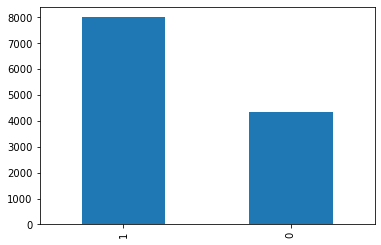

In [427]:
train_data['label'].value_counts().plot(kind = 'bar')

In [428]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   4357
1      1   8005


In [429]:
print(train_data.isnull().values.any())

False


In [430]:
print(train_data.isnull().sum())

review    0
star      0
label     0
dtype: int64


In [431]:
train_data.loc[train_data.review.isnull()]

,review,star,label


In [432]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [433]:
print(len(train_data))

12362


In [434]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-434-9263ec25ae0b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,review,star,label
19373,팔목에 착용하니 모양때문에 불편한듯 햇으나 금방 적응했어요 홈버튼있어서 편해요간편하...,5,1
8935,귀싸이즈가 안 맞고 한쪽이 자꾸 빠져요,1,0
10715,만원 넘게 주고 샀는데연결이 두쪽다 안되네요내돈으로 편하게 택배로 받을랬는데담주에 ...,1,0
20301,쉐어링이 힘들지만 괜찮아요,2,0
25334,아직 케이스는 못샀지만 진짜 좋습니당 영상보는 용도로 샀는데 영롱,5,1


In [435]:
test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3025


<ipython-input-435-1f0ed5dc41ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
<ipython-input-435-1f0ed5dc41ef>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-435-1f0ed5dc41ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\ProgramData\Anaconda3\lib\sit

In [436]:
train_data['review'] = train_data['review'].str.replace('^ +', "")
train_data['review'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

review    13
star       0
label      0
dtype: int64


<ipython-input-436-e5b57724600d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace('^ +', "")


In [437]:
train_data.loc[train_data.review.isnull()][:5]

,review,star,label
25330,NaN,5,1
25790,NaN,3,0
23701,NaN,5,1
24393,NaN,4,1
18416,NaN,5,1


In [438]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

12349


In [439]:
okt = Okt()
stopwords = ['가','게','고','과','네','는','다','도','들','듯','를','에','와','으로',
             '은','을','의','이','인','임','자','잘','좀','지','하다','한', '면', '수', '캔',
             '에서', '것', '요', '인데', '라', '애플', '사은', '워치', '핸드폰', '노캔', '에서는', '니까',
            
            '배송', '로', '만', '때', '제', '이라', '정도', '써리', '거', '서', '나',
             '중', '점', '월', '그', '하', '시', '용', '에는', '사', '년', '랑', '곳', '걸', '라서', '니', '처럼',
            
            '청춘팟', '플러스', '아이폰', '삼성', '에어팟', '버즈', '프로']

In [440]:
X_train = []
for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [441]:
print(X_train[:10])

[['팔목', '착용', '모', '양', '때문', '불편하다', '햇으', '금방', '적응하다', '홈', '버튼', '있다', '편하다', '간편하다', '쓰기', '넘다', '좋다', '추천', '추천', '이다', '덩'], ['귀', '싸다', '이즈', '안', '맞다', '한쪽', '자꾸', '빠지다'], ['만원', '넘다', '주다', '사다', '연결', '두', '쪽', '안되다', '내', '돈', '편하다', '택배', '받다', '랬', '늘다', '주', '서비스', '센터', '가게', '생기다'], ['쉐어', '링', '힘들다', '괜찮다'], ['아직', '케이스', '못', '사다', '진짜', '좋다', '습', '니당다', '영', '상보', '용도', '사다', '영롱'], ['솔직', '후기', '이다', '장점', '전', '쓰다', '폰', '옛날', '폰', '카메라', '전', '보다', '좋다', '쨍', '느낌', '얼굴인식', '화면', '열기', '좋다', '얼굴인식', '안되다', '문', '인식', '열다', '좋다', '마스크', '쓰다', '경우', '문', '인식', '굿', '인시', '매우', '되다', '용량', '기존', '보급', '보다', '좋다', '듀얼유심', '되다', '속도', '기존', '쓰다', '보급', '폰', '보다', '빠르다', '편임', '자급', '폰', '이기', '때문', '통신사', '어플', '없다', '좋다', '미리', '모트', '라는', '어플', '깔다', '티비', '리모콘', '사용', '좋다', '단점', '가격', '대비', '제품', '성능', '좋다', '제품', '에러', '확인', '결과', '개', '에러', '발생', '되어다', '가끔', '화면', '아랫', '부분', '하얗다', '발생', '되다', '불량', '오류', '하이마트', '문의', '수령', '일로', '부터', '일', '이내', '센터', '불량', 

In [442]:
X_test = []
for sentence in test_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
print(X_test[:10])

[['공식', '대리점', '맞다', '박스', '걍', '재활용', '이던', '데', '쇼핑', '백', '왜', '없다', '파손', '되다', '물건', '옴', '배달', '지다', '더', '늦다', '도착', '물건', '먼저', '올', '늦다', '예쁘다', '깔끔하다', '이쁘다', '자다', '사용', '하고', '있다', '이전', '써다', '차이점', '빛', '훨씬', '더', '모으다', '지다', '아직', '완전하다', '좋다', '좋다', '좋다', '앙', '좋다', '어', '저하', '오', '저', '여', '오주', '때문', '애', '간장', '녹이다', '크리스마스', '선물', '다행하다', '뙇', '나타나다', '예쁘다', '사려', '거의', '주', '동안', '들락날락', '같다', '처음', '엔', '그렇게', '절박', '않다', '자다', '쓰다', '있다', '좋다', '물건', '감사하다', '테스트', '대다', '구입', '만족하다', '연말', '시키다', '쪼금', '미루다', '빠르다', '펴다', '같다', '저희', '지역', '오프라인', '문제', '없다', '아니다', '나름', '잘쓰다', '역시', '맥', '기대하다', '최고', '비싸다', '정말', '자다', '사다', '생각', '듭니', '오래오래', '자다', '일', '걸리다', '제품', '좋다', '정확하다', '평일', '오후', '접수', '되어다', '다음', '날', '오', '후시', '받다', '랩핑', '포장', '뽁뽁이', '상자', '한번', '더', '싸', '주다', '좋다', '엄청나다', '빠르다', '감사하다', '다른', '개월', '걸리다', '전화하다', '물건', '보내다', '전', '상품', '문의', '글', '안', '읽다', '보시', '보다', '물건', '오다', '아직도', '글', '이번', '건', '되다', '근데', '저번', '건', '두', '대로

In [443]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [444]:
print(tokenizer.word_index)

{'좋다': 1, '있다': 2, '받다': 3, '자다': 4, '보다': 5, '사용': 6, '너무': 7, '되다': 8, '같다': 9, '구매': 10, '제품': 11, '빠르다': 12, '없다': 13, '이다': 14, '오다': 15, '쓰다': 16, '않다': 17, '안': 18, '사다': 19, '하고': 20, '가격': 21, '들다': 22, '만족하다': 23, '생각': 24, '주문': 25, '더': 26, '일': 27, '기능': 28, '상품': 29, '되어다': 30, '아니다': 31, '정말': 32, '저': 33, '많이': 34, '노트북': 35, '안되다': 36, '선물': 37, '가다': 38, '폰': 39, '구입': 40, '써다': 41, '갤럭시': 42, '적': 43, '음질': 44, '저렴하다': 45, '케이스': 46, '이어폰': 47, '처음': 48, '포장': 49, '고민': 50, '못': 51, '감사하다': 52, '이쁘다': 53, '그렇다': 54, '예쁘다': 55, '문제': 56, '크다': 57, '괜찮다': 58, '디자인': 59, '해보다': 60, '조금': 61, '바로': 62, '그냥': 63, '없이': 64, '충전': 65, '다른': 66, '성능': 67, '화면': 68, '소리': 69, '색상': 70, '아주': 71, '해주다': 72, '아쉽다': 73, '까지': 74, '걸리다': 75, '편하다': 76, '가볍다': 77, '비': 78, '많다': 79, '센터': 80, '착용': 81, '넘다': 82, '시간': 83, '불량': 84, '택배': 85, '마음': 86, '쓸다': 87, '가성': 88, '분': 89, '진짜': 90, '서비스': 91, '귀': 92, '주다': 93, '좋아하다': 94, '느리다': 95, '아직': 96, '모르다': 97, '일단': 98, '보내다': 9

In [447]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12373
등장 빈도가 2번 이하인 희귀 단어의 수: 6113
단어 집합에서 희귀 단어의 비율: 49.405964600339445
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7825810194700409


In [448]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6261


In [449]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [450]:
print(X_train[:3])

[[2617, 81, 1489, 1215, 138, 103, 755, 1276, 1532, 676, 2, 76, 1014, 421, 82, 1, 158, 158, 14, 2270], [92, 142, 2717, 18, 133, 237, 527, 221], [228, 82, 93, 19, 113, 172, 549, 36, 232, 413, 76, 85, 3, 5353, 280, 169, 91, 80, 2815, 457]]


In [451]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [452]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [453]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

12342
12342


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 1296
리뷰의 평균 길이 : 33.879598120239834


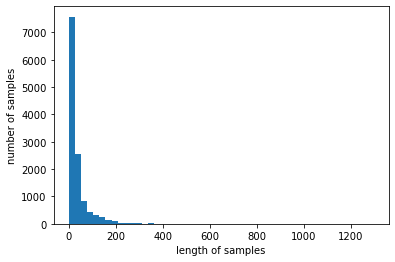

In [454]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [455]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [456]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 89.10225247123643


In [457]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [458]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [459]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_ = []

for i in range(len(y_pred)):
    if y_pred[i][0] > 0.5:
        y_pred_.append(1)
    else:
        y_pred_.append(0)
y_pred_

confusion_matrix(y_test, y_pred_)

array([[ 570,  488],
       [1020,  947]], dtype=int64)

In [460]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [461]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
165/165 [==============================] - 47s 272ms/step - loss: 0.5421 - acc: 0.7271 - val_loss: 0.8433 - val_acc: 0.6136

Epoch 00001: val_acc improved from -inf to 0.61361, saving model to best_model.h5
Epoch 2/15
165/165 [==============================] - 38s 228ms/step - loss: 0.4512 - acc: 0.7918 - val_loss: 0.5003 - val_acc: 0.7542

Epoch 00002: val_acc improved from 0.61361 to 0.75415, saving model to best_model.h5
Epoch 3/15
165/165 [==============================] - 35s 212ms/step - loss: 0.4213 - acc: 0.8109 - val_loss: 0.5035 - val_acc: 0.7513

Epoch 00003: val_acc did not improve from 0.75415
Epoch 4/15
165/165 [==============================] - 32s 197ms/step - loss: 0.3974 - acc: 0.8222 - val_loss: 0.5171 - val_acc: 0.7473

Epoch 00004: val_acc did not improve from 0.75415
Epoch 5/15
165/165 [==============================] - 30s 181ms/step - loss: 0.3796 - acc: 0.8345 - val_loss: 0.5250 - val_acc: 0.7465

Epoch 00005: val_acc did not improve from 0.75415
Epo

In [462]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

95/95 [==============================] - 5s 45ms/step - loss: 0.4809 - acc: 0.7736

 테스트 정확도: 0.7736


In [463]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [464]:
sam = pd.read_csv("C:/690009/TP2/final_project/member/NTJ/crawlerNsReview/data/PP/sam.csv")
sam

,Unnamed: 0,내용,등록일
0,0,사람들이 불만이 많아 걱정 많이했습니다사고 난 1일7일 발열 느껴졌습니다하지만 이 ...,2021.08.12. 10:54
1,1,s10 5g에서 기변했는데 카페글에 발열 심하다는 얘기가 많아 불안했지만 카메라가...,2021.08.12. 10:39
2,2,s21울트라로 기변했습니다침수된 s20는 as비용만 8090만원이 나오는지라저렴하게...,2021.08.10. 07:09
3,3,안녕하세요4월 말에 구매해서 지금까지 울트라 잘 사용하고 있습니다s21시리즈 문제때...,2021.08.09. 17:50
4,4,사용기종 s21최대가 3435도고 카메라 사용시 36도까지 찍었네요,2021.08.09. 17:00
...,...,...,...
1877,1877,역시 1세대 기술이라서 기대 전혀 안했는데요생각보다 티가 많이나네요저는 좀 예민한 ...,2021.08.12. 13:07
1878,1878,폴드2 사용중입니다이번에 UDC 펜 지원 방수 된다고 한데다 리뷰 영상보고 눈돌아...,2021.08.12. 12:45
1879,1879,udc 쫌 이상함,2021.08.12. 12:43
1880,1880,폴드2랑 디자인은 별 차이가 없지만 UDC디스플레이는 좋네요근데 아쉬운점은 흰화면에...,2021.08.12. 11:57


In [465]:
sam.drop_duplicates(subset = ['내용'], inplace=True) # 중복 제거
sam['내용'] = sam['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
sam['내용'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
sam = sam.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(sam))

전처리 후 테스트용 샘플의 개수 : 1422


<ipython-input-465-195377d8e736>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  sam['내용'] = sam['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [466]:
n = 0
for i in sam["내용"][:]:
    n += 1
    print(n)
    sentiment_predict(i)
    print(i)
    

1
94.17% 확률로 긍정 리뷰입니다.

사람들이 불만이 많아 걱정 많이했습니다사고 난 일일 발열 느껴졌습니다하지만 이 전 이용폰이랑갤  비슷했습니다 최고온도 한 도 가끔 영화 다운받아 보고  모바일 장시간 이용 했습니다 충전시도 열 느껴짐카메라는 잘안써서 이용시 잘모르겠습니다일일 발열 아예 안느껴집니다 체감상  보다 안느껴짐  모바일 영화 다운 아프리카 시청 유튜브 사용 전혀 발열 안느껴집니다카메라 미사용 유튜브에서 실험했던 열테스트들은 스마트폰 극대로 사용해서 테스트 해서 발열이 있나봅니다그냥 일상생활 폰 사용 하시는분들은 열 걱정 없이 구입하셔도 될꺼같아요
2
85.72% 확률로 긍정 리뷰입니다.

  에서 기변했는데 카페글에 발열 심하다는 얘기가 많아 불안했지만 카메라가 너무 탐나서 구입했는데결론은  보다 발열 덜한것같아요발열 이슈 있는 제품은 맞지만 특시 심하신분들이 여기 카페 가입 많이 하셨나봅니다
3
75.49% 확률로 긍정 리뷰입니다.

울트라로 기변했습니다침수된 는 비용만 만원이 나오는지라저렴하게 구매했어요 
4
87.85% 확률로 긍정 리뷰입니다.

안녕하세요월 말에 구매해서 지금까지 울트라 잘 사용하고 있습니다시리즈 문제때문에 고생하시는 분들한테 죄송하지만 구매 예정이신 분들한테 참고가될까 싶어서 올립니다제가 알기론  통신사 기준 공시지원금 다시 늘린다고하더라고요저는 자급제로 구매했습니다암튼 방금 업뎃 끝냈고 사진 인증합니다시간이랑 온도 보시면되세요먼저 긱벤치 점수 형광펜이 업뎃 이후 연속으로 한 거에요 써머가디언 가 단계로 내려오긴 했는데 이건 업뎃하고 바로 긱벤치 연속으로 돌려서 좀 내려간 거 같네요업뎃이랑 긱벤치 돌리면 온도가 올라가요이용환경은 다들 하는 것처럼 인터넷 유튜브하고 게임은  피파 카트  아스팔트합니다
5
91.37% 확률로 긍정 리뷰입니다.

사용기종 최대가 도고 카메라 사용시 도까지 찍었네요 
6
94.21% 확률로 긍정 리뷰입니다.

성능을 반으로 줄여서 발열을 잡으면 그게 플래그쉽입니까  후면 카메라 디자인 너무 

80.81% 확률로 긍정 리뷰입니다.

제가 년부터 지금까지 갤럭시 를 시작으로 갤노트 갤노트 갤럭시 아이폰프로맥스 울트라 이렇게 스마트폰을 써왔는데요단 한번도 발열때문에 이토록 스트레스를 받은적이 없습니다아이폰은 적어도 게임 영상촬영 할때 아니면 발열 있는지도 몰랐습니다그전에 쓰던 폰들도 마찬가집니다 카톡 웹서핑 유투브시청 등 일반적인 사용에서 발열 느낀적 없습니다그런데 이번 울트라는 심해도 너무 심합니다그냥 인터넷 웹서핑만 해도 뜨거워집니다모드이건 모드이건 상관없습니다 발열은 동일합니다제가 뽑기를 잘못한건지 너무 궁금해서 주변  울트라 사용자 명  사용자 명한테 물어봤는데 모두가 동일합니다이 몇명으로 전체를 일반화 하지 말라고 하실수도 있습니다 그런데 카페의 다른 사용자분들도 그렇고 삼성멤버스에 올라오는 글도 그렇도 보면 많은 분들이 동일한 문제를 겪고 있음을 알게 되었습니다발열로 휴대폰이 터지지 않으면 문제가 없는건가요아니 제가 폰으로 고사양 게임을 하거나 왠종일 카메라를 켜놓거나 하는거면 이런 불만 가지는 것 자체가 웃기는 일이겠죠그냥 화면만 켜져있으면 뜨거워집니다 진짜 딱 그래요로 주사율 내리면 좀 괜찮아지더군요 근데  지원하는 폰에서 로 내려서 쓸거면 왜 이가격을 주고 플래그십 폰을 삽니까 되는 폰에서 를 써야한다면 왜 요금제를 내고  단말을 구매하죠까지 촬영되는 카메라를 샀는데 왜 급 화질로 촬영을 해야하죠이든 든 울트라든 발열문제는 모두 동일한 듯 보입니다시리즈로 기변생각있으신 분들 정말 짐싸들고 찾아다니면서 말리고 싶습니다 절대 바꾸지 마세요게임 안하면 괜찮다고요 실사용에서는 발열이 체감되는 수준이 아니라고요 사람마다 다를수 있겠지만 제 기준에선 아닙니다 전혀 아니에요그냥 화면이 켜져있으면 뜨거워집니다 적어도 제 경험상 그렇고 주변 사용자들도 동일한 문제를 겪고 있어요업데이트 다 최신버전입니다 발열개선 업데이트 그것도 당연히 되어있습니다발열개선은 도대체 뭔 발열개선을 했다는건지 소비자 눈속임인지 뭔지 모르겠는데 전혀 개선된 부분을 체감하지 못하

74.26% 확률로 부정 리뷰입니다.

게임잘안하다가 요즘 폰게임 살짝시작했는데진짜 렉오지게걸리네 시작하고 한분지나면 존나게 끊겨서 열오지게나고 할수가없음 개쓰레기폰
61
88.90% 확률로 긍정 리뷰입니다.

박일고민끝에발열문제있어도디자인때문에 너무끌렸던 플러스로했어용가게사장님께서 몇개꺼내시길래제가직접손으로골랐어요다행히바이올렛이있었고뽑기운이라는데제가뽑아야남탓안할듯해서요근데 저겜은원래안하고 하루종일 개통하고나서인스타눈팅이나 카톡 인터넷검색 넷플릭스도시간가까이봤는데소프트웨어 업뎃할때 진짜폭발하는줄알고근데지금까지열이확식고난뒤에는괜찮네요확차가운게아니고 폰좀잡고있음 나는미열정도요전에갤노트썼는데 그때도폰많이붙잡고있음미열은있었거든요아무튼일지나거나일줄뒤에 발열심하시단 글도봤는데조마조마하며 폰을다뤄봐야겠습니당후회해도 제가쓰고픈거쓰는게 맘편할거같아서 로넘어왔습니당앞으로잘부탁드려요 정보도많이얻어가겠습니다감사합니당근데카메라진짜넘 좋아요저는진짜차고넘칩니다 밥먹고나와서 한번찍어봤어요
62
82.37% 확률로 긍정 리뷰입니다.

저는 부모님께서 최신모델로 사주셨습니다 발열은 대부분 전면 카메라 쓸때 나고 대부분은 열이 나지 않습니다 물론 다른 사람마다 다르겠지만 디자인 램 문제 이긴 하나 속도는 매우 빠릅니다 후면 카메라는 좋습니다 아이폰으로 갈아타고 싶은 마음이 들긴 했지만 삼성페이 때문에 못갈아타겠더라구요 지금 보니 저는 도 괜찮다고 보네요
63
57.19% 확률로 부정 리뷰입니다.

전 자급제  울트라 한정판 티타늄  쓰다가옆면 도색된 부분이 떨어져서서비스센터 갔더니유료로 수리 받았네요  열이 문제일까요
64
84.30% 확률로 긍정 리뷰입니다.

 두기기 모두 최대한 비슷한 사용환경에서 사용 후 측정한 수치 입니다혹시나 저도 헷갈릴까봐 팝업으로 휴대폰 정보띄워놓고 캡쳐해봤 습니다 수치로만 보면  쓰로틀링이나 발열정도나 큰 차이가 없어보이는데 실제로 그럴진 잘 모르겠네요 
65
97.60% 확률로 긍정 리뷰입니다.

월일에 바꾸고 한 주썼네요굉장한 라이트유저여서 발열 별로 못느꼈

89.37% 확률로 부정 리뷰입니다.

질문추천 금지  전반보고 후반보고 있는지금 배터리는  온도는 도  현재 폰 상태는 겁나게 뜨겁고 렉걸린것처럼 화면 스크롤도 버벅버벅도대체 폰으로 보라는건지 말라는건지휴 분뒤도  
87
78.89% 확률로 긍정 리뷰입니다.

에서 로 옮긴다고 글 올리고 걱정해 주신분들이 계셨지만깨진 액정을 보고 그냥발열 보는   앱으로 보시던데 저도 설치해보았어요아래 캡처와 같이 앱을 정리해주는 기능인거 같은데 정리 후 바로 다시 보면 앱이 그대로 보이는데 다른 설정이 필요한가요
88
58.42% 확률로 긍정 리뷰입니다.

싱글에 멀티 정도 나오네용  
89
70.27% 확률로 긍정 리뷰입니다.

평소 사용량은 인터넷 카톡 유튜브 이메일 화상회의 정도입니다 인스타페북 같은 는 안합니다 아래는 제가 해놓은 설정인데요다크모드절전모드 화면주사율    꺼짐네트워크 사용환경  와이파이   자연스런 화면 셋팅편안하게 화면보기초고속충전고속충전고속무선충전 모두 개발자옵션   창 애니메이션 배율 사용안함  전환 애니메이션 배율 사용안함   길이 배율   상 온도그래프 가장 왼쪽으로 셋팅배터리도 엄청 오래가고 화상회의 켜놓고 네이버앱  인터넷 및 카톡 동시에 해도 열이 거의 안올라오는 경지에 이르렀습니다년에 플래그십 모델 사용법그냥 허탈합니다 
90
84.17% 확률로 긍정 리뷰입니다.

어제일자로 갤 에서 울트라로 넘어왔는게 무게감이 덜덜하네요
91
97.46% 확률로 긍정 리뷰입니다.

이틀차 후기입니다는 처음써보는데 체감많이옵니다역체감이 크다고들 하던데저는 처음볼때부터 순체감이 더 컷습니다드레그할때 진짜 부드럽네요 뽑기는 실패한듯 발열 있습니다특히 카메라키면 훅오네요게임할때도 손난로되고 그렇네요같은게임 같은옵션으로 돌리면 전에 쓰던 보다도 뜨겁습니다근데 이것보다 짜증나는게 화면이 좀 누렇습니다붉은끼를 누렇게 커버한것 같기도 하고요화면 누런거는 시리즈 종특인지때도 그러더만 때는 벚꽃에디션으로 액정갈았었는데제조월은 이고 구입처는 입니다 자급제폰이며 만원 

71.51% 확률로 긍정 리뷰입니다.

마구마구 유저입니다업뎃 전에는 풀옵으로 실행 시 뜨거워도 잘 돌아갔지만 업뎃 후에는 발열이 확실히 줄었지만 프레임 저하가 일어나네요
125
83.05% 확률로 긍정 리뷰입니다.

업데이트 이후 발열이 없네요 너무 만족합니다 
126
82.38% 확률로 긍정 리뷰입니다.

 쓰다가 년개월만에 바꿨습니다너무 간만에 폰을 바꾸다보니그냥 너무 빠르고 좋습니다
127
55.58% 확률로 부정 리뷰입니다.

 
128
95.08% 확률로 긍정 리뷰입니다.

 울트라 유저입니다카메라 배터리가 좋아서 잘 쓰고 있는데 딱 두가지무게와 발열 때문에 좀 그렇긴 했습니다무게는 얇은 케이스를 쓰면 되는데발열은 불쾌까진 아니더라도 발열이 솔솔 올라왔습니다여기서 원신 돌리면 으아아아아아그러던 중 업뎃나와서 업뎃하고 써봤습니다더 이상 인터넷 중엔 발열을 느낄 수 없었습니다뜨뜻한 느낌이 싹 사라졌습니다그런데 보통 소프트웨어로 발열 내리는 방법은 언더볼팅이나 성능 너프거든요로 치면 평소엔 쿨럭을 내려 소음과 발열을 줄이거나 하는 거지요아니면  전력을 줄이는 일명 언더볼팅이 있는데 이건 잘못 건드리면 큰일납니다그래서 폰으로 원신 돌려봤는데 발열은 확연히 줄어들었습니다 체감이 확 옵니다성능하락은 아직 체감 못하겠네요 원래 풀옵은 불가능한 게임이니 그런 걸지도요음 이게 가능한진 모르겠는데 제 생각엔 삼성이 언더볼팅 비스무리한 걸 한 것 같기도 합니다이 또한 발열제어를 위한 거긴 하니까요
129
52.41% 확률로 긍정 리뷰입니다.

결론부터 말씀드리자면 눈에 보이지 않는 쓰로들링을 건것 같아요 네이버 카테고리 왓다갓다 넘길때마다 전에는 엄청 부드러웟는데 업뎃후에는 야악간 버벅임이 느껴집니다 유튭도 그렇구요
130
92.09% 확률로 긍정 리뷰입니다.

이번 업데이트로미지근한 발열까지 잡힌거 같아대만족입니다 업뎃 전에는 불쾌하지 않은 정도로 발열감이 살살 올라왔는데지금은 사용시에발열이라는 단어도 잘 생각이 안나네여 진짜 굳입니다
131
63.20% 확률로 긍정

57.20% 확률로 긍정 리뷰입니다.

아무것도 안하고 있었는데 휴대폰 온도가 도가 나오는데 인데 정상인가요
161
57.50% 확률로 부정 리뷰입니다.

게임 전혀 안하고요 카메라도 안썼습니다 웹서핑밖에 한 게 없네요 삼성스마트폰카페 게시물 몇 개 봤더니 이정도입니다 저 정도면 많이 심한건가요 추가긱벤치 스코어와 긱벤치 돌렸을 때 단말 온도입니다 
162
74.59% 확률로 긍정 리뷰입니다.

 그닥 심하지는 않은거 같긴한데요간만에 아이폰에서 넘어온건데 이런 발열이슈있으니그닥 좋지는 않네요아이폰나오면 고려해봐야겠어요집에를 로 올려봤는데 오히려 더 빠릿한느낌이 들더라구요 삼페와 를 포기하기도 그렇고
163
84.84% 확률로 긍정 리뷰입니다.

평상시에 게임은 중간에 푸쉬템만 받고끌정도이고 영상은 폰으로 즐겨보는편은 아니지만이렇다할 높게 올라간 기준은 없네요그치만 더 좋은폰 나오면 갈아탈꺼같습니다엑시노스 이건 아닌거같아요 앞으로 엑시노스는 걸러야될꺼같지만때문에 앞으로 폰은 신중하게 고르고통신사쪽에서 좋은 조건 나오면 바로 갈아타야될꺼같습니다요새  옛날 같지않은건 익히 들었습니다만좀 그렇네요
164
68.92% 확률로 부정 리뷰입니다.

오늘 글 올라온 거 다 봤는데저보다 심하신 분들도 나오신 거 같아요저는 도인데그분은 도정도 보였습니다 후
165
79.81% 확률로 긍정 리뷰입니다.

질문 판매글 광고 체험단글 추천요구글   판매처 또는 인터넷주소링크 금지  가짜모방특히명품 액세서리   제품도착 지연 문의글 한줄 후기  질문추천 금지 발열 때문에 계속 고민하다 결국 어제  구매했습니다며칠 전 올린 고민 글에 뽑기 운이 강하다 많이 뜨겁다 괜찮다는 의견이 섞여있어 사지 않으려 했는데안사면 몇 주 계속 고민하다 결국 살 것 같아 그냥 매장 다녀왔어요개인적으론 굉장히 만족스럽습니다이전 폰보다 훨씬 부드러운게 체감되고 뽑기 운이 좋아서 그런지 발열도 별로 없는 것 같습니다개인적으론 업데이트 자료 옮기는 동안 뜨겁다는 느낌 못받았고 충전하는 동안에도 괜찮았습니다아직 게

65.74% 확률로 부정 리뷰입니다.

 도 배터리 도 갤러리에서 사진편집하는 것만으로도 심각한 버벅거림  모니터라는 어플이 부정확해서 믿고 걸러야 한다는 의견이 있어서해당 시간의 갤럭시랩스의 서멀가디언도 첨부합니다몇도인지 표시하지도 않고 표정으로만 표시되는서멀가디언도 거를까요삼성멤버스에 로그 보냈습니다한가지 알아낸 점은 다른 분들도 는 도 올라간다고 하지만온도가 도일지언정배터리는 도이하를 유지하려고 한다는 것을 알게 되었습니다간혹 배터리온도가 도를 넘어도 곧바로 도이하로 내려간다고 하네요저는 배터리 온도가 온도를 따라가고 있기 때문에온도가 도 찍으면 배터리온도는 도온도가 도면 배터리온도는 도온도가 도면 배터리온도는 도 이런식으로 배터리가 도이하를 유지하지 못하고 있습니다해당 스샷은 시 분 스샷이고네이버카페에 글쓰는 시 분 분간 온도는 내려가서 도 배터리 도로 아직도 뜨거운 편입니다 테스트 종료 후 분 경과 온도 도 배터리온도 도뜨끈합니다 그래도 높네요 월 일  도 배터리 도삼성서비스센터 방문  정상해당 글은 의 발열이슈가 아닙니다인터넷으로 엄청 많이 검색해봤습니다 발열이슈는 아무리 높아도 도입니다유튜브 후기 다 뒤져보아도 최고온도가 도전후입니다저처럼 몇분만에 도가 되고 분 지나면 도가 되지는 않아요이게 발열이슈면 다들 저처럼 도까지 올라가야죠다른 폰은 도이하를 유지하는데제 폰은 도면 불량이죠발열 불량인 폰을 센터가 정상이라고 하면서불량판정을 해주지 않는 데에어이가 없어서 쓰는 글입니다
186
72.52% 확률로 부정 리뷰입니다.

컴퓨터에 케이블 연결하면충전만 되고 대용량장치로 인식이 안되네요오늘 서비스센터 갔다와서 충전단자 모듈 교체했는데증상 똑같다고 다음 케이블 연결단자 교체해본다네요근데 재고 없어서 내일 다시 와달라고 그거까지 교체하고 똑같으면 메인보드 교체냐니까맞다네요번을 뜯게 생겼어요 
187
92.87% 확률로 긍정 리뷰입니다.

사용 용도  유튜브 웹서핑시간 유튜브 봐도 발열 거의 없는 것 같네요충전할 때도 발열 적고 시간이 지날 수록 안정화가 

92.97% 확률로 긍정 리뷰입니다.

안녕하세요 용집자 입니다   를 구입하여 달 조금 넘도록 쓴 후기를 알려드리려고 합니다 디자인디자인은 깔끔깔끔 무난무난 합니다후면 헤이즈 디자인이 맘에 들고 느낌이 좋아서 케이스를 안쓰고 있을 정도에요 카메라사실 요즘 최근에 나오는 갤럭시 스마트폰에서 가장중요한것은 카메라인거 같습니다삼성도 카메라를 밀고 있고 일단 그냥 찍어도 사진의 품질 좋습니다선명하고 질감표현력도 훌륭합니다 근데 너무 밝게찍는감이 있지요제가  울트라를 쓰면서 제일 맘에 드는것중 하나가사진이 정말 잘 나온다는겁니다학교에서 여자애들이 제꺼로 사진을 찍으면 이거 그폰 아니야 하면서 아이폰 만큼은 아니지만 화질이 선명하다고 합니다저는 풍경사진 찍는건 좋아하는데 셀카는 안찍어서 전면카메라는 화질이 어떤지 잘몰랐거든요특히 어두운 밤에 찍어도 밤에서 아침되가는것처럼 하늘이 좀밝게 나와서 어색하긴 한데 그래도 야간품질좋아요또 마음에 드는건 매크로모드를 쓸수있다는것이죠가까이 다가가면 초점 향상을 위해 근접 촬영 기능을 켰어요 라고 뜨면서 가까운곳에서도 초점을 잡고 접사로 찍을수있습니다 배터리배터리는 사실 제가 서브로 쓰려고 구입해서 배터리는 별로 신경은 안쓰려 했으나  충전후 사용시간이  시간이에요다른 분들보니까 일거뜬히 넘기시던데 저는 좀 막써서 그런지 시간가요근데 배터리는 오래가는편 입니다체감상으로는유튜브를 그냥보는데도 배터리 충분히 오래가고요 쓸만합니다아마 디스플레이에서 절전되고 엑시노스 칩셋이 나노공정에다가 랑 원칩으로 통합되있기도 하고 그래서 그런지 오래갑니다그리고 저는 상태에서 절전모드를 쓰고 있어 약간 더 오래가는것 같기도 하구요충전속도도 빠릅니다 성능사실 이부분이 논란이 많죠화시노스라는등등 똥시노스근데 막상써보거나 예전 엑스노스 생각하면 많이 나아졌긴합니다만 게임돌리는데도 크게 문제는 없었어요근데 발열은 아주아주 정말 심합니다제가 제  울트라에게 뜨끈뜨끈  울트라라고 별명을 짓기도 했습니다 발열때매 게임성능제한도 조금 걸리고요제건 카메라 찍는거많으로도 

86.34% 확률로 긍정 리뷰입니다.

당근에서 앞면 무기스에 뒷면 부분깨짐 에 구매했는데  부드럽네요 옷을 빨리 입혀줘야 되는데추천케이스 있나요아그리고 램이 니까 기본으로 잡아먹는 램도 높아지더라구요신세계
217
87.86% 확률로 부정 리뷰입니다.

잘 알아보지않고 구매한 내 잘못인가삼성의 소비자 기만인가  
218
53.39% 확률로 긍정 리뷰입니다.

반응속도가 장난아니네요큰 기다가 됩니다
219
92.20% 확률로 긍정 리뷰입니다.

아이폰 기종을 아이폰 판매 끝무렵에 구매해서 년 이상을 썼네요문제없이 잘 사용했는데 아이폰 업데이트 중지에 속도 저하에 아 이젠 바꿔야겠다 싶어서 아이폰 미니 아이폰 프로  갤럭시  중에 많이 고민했었네요갤럭시 버즈 갤럭시탭을 사용하고 있어서 갤럭시 로 넘어왔네요다른 것 보다 사진 화질이랑 오래 써서 느려진 아이폰보다 어플 반응 속도가 빨라져서 너무 만족스럽네요발열은 그럭저럭 괜찮았는데 소프트웨어 업데이트 될 때 엄청 뜨거워지더니 그 왜에는 큰 발열을 아직까진 느끼지 못했네요앞으로도 발열이 큰 문제가 안 되었음 좋겠습니다 갤럭시 과 잘 살아봐야겠습니다
220
93.32% 확률로 긍정 리뷰입니다.

노트  쓰다가 너무 느러져서 바꿔야지 버티고 있었는데노트은 디자인이 영 아니여서 년을 더 기다렸는데올해는 노트가 안나온다하여 어쩔 수 없이 플러스로 잠깐 갈아탔습니다내년에 노트가 나오면 다시 바꿔야겠어요노트야 기다려
221
88.48% 확률로 긍정 리뷰입니다.

월일부로   권리실행가능해서 고민끝에 로 갈아탔습니다 대리점 샵과 거즘비슷합니다넌 어짜피 여기밖어 못한단식 판매점 몇군데 돌아다녔는데 슈퍼체인지 받아준다고는하는데 가격을 후려치려고 하더군요반납폰 만 풀로받아도 만가량 손해감소하란식디플가서 슈퍼체인지 권리실행 물어보니 된다해서 가격보니 만족스럽습니다 만요금 개월사용 할부원금 만 정도에 반납도 바로해주시더군요기계값바로 포인트들어와서 남은할부금 정도 개월로 요금에 포함되서 나간다네요슈퍼체인지 권리실행하시는분들 대리점 가보시고 

89.74% 확률로 긍정 리뷰입니다.

갤 일주일 사용 후기입니다갤 사고 가장 걱정되는 부분이배터리랑 발열이였는데요다행히 저는 양품인지 발열은 없는거 같아요아직까지 엄청 뜨거움은 경험하지 못했어요첫날 데이터 옮기고 충전하고 그럴 때만 좀 따뜻했는데그 후론 괜찮았습니다저는 게임은 안하구요주된 사용은 가끔 유튜브 인터넷 카톡 쇼핑 이북 정도입니다오늘은 페이스톡 시간 했는데혹시나 발열이 있을까 중간에 만져봤는데발열이 없네요배터리는 페이스톡 전후  정도 차이 있었어요페이스톡 하기 전에 였는데 페이스톡 시간 하니  줄어서  정도 남아있더라구요카메라가 좋은 거 같습니다폴드는 카메라가 별로였는데점심 먹고 식당에 거위가 있어서 배 줌 해서 찍어봤는데 거위 털에 기어가는벌레가 보이더라구요 벌레가 너무 잘 보여서 깜놀했어여일주일 후기 만족합니다 고민하시는 분들께 참고가 되었음 해요
259
71.53% 확률로 긍정 리뷰입니다.

업뎃하고 앱부스터 한번 돌리니 발열이 많이 없어졌네요 이젠 충전기 꼽고 겜해도 온도가 도를 안넘어가네요 개인적으로 업뎃 잘했다고 생각합니다 
260
60.54% 확률로 긍정 리뷰입니다.

진동이 진짜 센편인데 터치진동세기 조절이 미세하게 안되네요 쓰다와서 많이 만족스럽긴한데요은 미세진동세기까지 조절 가능했는데는 가진가까지만 조절 가능하고단계 넘으면 너무 쎄네요이건 업데이트해서 고쳐주면 좋겠어요
261
93.67% 확률로 긍정 리뷰입니다.

회사 대리점에서 행사로 싸게 나와서 한달전에 만원 지원받고 에서 갈아탔는데 만족하면서 쓰고 있습니다굿락도 이번에 처음 써봤는데 유용한게 많네요처음에  하려다가 후면 플라스틱과 구형 진동 모터가 맘에 거려서 로 결정했구요화면 큼직하고 디자인도 마음에 들고 원래 년 쓰다가 적당한 걸로 바꾸면서 대충 썼는데 폰바꾸고 이정도 만족스러운 적은 처음입니다뽑기가 잘된건지 게임돌려도 발열없고 딱히 불만족스러운 부분도 없이 잘 쓰고 있습니다
262
72.27% 확률로 긍정 리뷰입니다.

쓰다 넘어왔는데 아직도  차거치대에 음감용으로 있

92.05% 확률로 긍정 리뷰입니다.

저는 평소 어떤 핸드폰이 램이 몇이고 스냅 무슨 노스였나 테크 지식 관련하여 잘 알지도 못 해서 이것저것 따지지 않고 약정 끝나면 그냥 단순하게 삼성 최신형을 구입하여 사용하는 사람입니다년 월 일  기본 바이올렛 개통 후 일째 됐는데 불편한 점이 딱 하나 있었기에 구입을 고민하시는 분들에게 약간이나마 도움이 되고자 후기 글을 작성하게 됐습니다딱 하나 불편했던 점은 바로 발열이었습니다저는 이제껏 폰 게임을 단 한 번 이용해 본 적 없으며 핸드폰 성능을 저하 시키는 등의 이용을항상 멀리 하면서 심플한 사용을 추구하는 사람입니다충전 또한 초고속으로 자주 하면 수명이 짧아진다기에 유선 충전으로 설정 해두고 잔량도 퍼센트 유지하면서 사용중입니다와이파이 가능한곳에서는 무조건 와이파이 사용하였고 그외에 장소에서는  는 무조건 꺼두었습니다개통 후 지금까지 절전모드 사용 중입니다 구입 후 이용 대부분은 통화 카카오톡 및 문자 카메라 사용 플로 음악듣기 유튜브 영상 보기 웨이브에서 드라마 시청 삼성브라우저에서 웹서핑 대략 이정도였습니다발열의 정도는 요즘 날이 더워져서 그런지 월에 비해 더욱 심했습니다사용하던 손이 미지근함을 넘어서 따뜻 뜨겁발열이 심해지고 있다라는게 아주 분명하게 느껴졌습니다써머가디언 들어가보면 역시나 빨간점은 여러개가 찍혀있었고 온도는 금일 최고 온도 도까지 찍혀 있는 것을 확인했습니다한 여름 폭염이 오면 어떻게 될지 걱정이 안될 수가 없습니다지금까지 삼성만 고집하며 여러 핸드폰 구입하여 잘 사용했었는데이번에 처음으로 후회란걸 해봅니다월경부터 삼성카페 이용하면서  발열 관련 글 서비스센터 방문 후기 등을 눈여겨봤었습니다분명 형식적인 발열 대처 메뉴얼이 있는거다몇 도가 넘어도 무조건 정상이라 일관한다 등의 글을 보고 가봤자 별 도움 못받겠구나라는 생각이 들어 체념을 했었습니다 그런데 요즘 발열 상태라면 조만간방문을 해봐야할것같습니다 구입 하기에 앞서 발열이 걱정이신 분은 한번쯤 심히 고심해보시는게 좋을듯합니다본문 모두 단 

81.95% 확률로 긍정 리뷰입니다.

일단 지난주 삼성디지털 프라자 대란탑승 했고 오늘 사은품 다 정리하여 내역 공개하면  자급제노트북버즈플러스 카드결재 원 개월 캐시백 원 청구할인 원  할부이자 원 원 에서  상품권 원 삼페카드 신규발급 원 노트북 처분가 원  버즈플러스 처분가 원  민팃 원  최종가 원에 구매완료 했네요 핸폰은 실사할지 팔지 고민중 입니다 안팔면 삼성 악세서리 구매쿠폰 만원 짜리랑 워치쿠폰 라이브 쿠폰도 있어서 더 내려가겠네요참고 바래요 
305
95.02% 확률로 긍정 리뷰입니다.

노트 단종각이라 이제 어떻게 둥근 디자인 쓰나 했는데바로 잊혀졌습니다 노트이랑 세대 차이도 나고크기 베젤 성능등 격차가 어마 어마 하다 보니 신세계입니다아주 싸게 산 것도 한 몫 하겠지요 어플 동시에 여러개 사용을 많이 하는데 리프레시 없는게 너무 좋네요발열도 없는 것 같고 양품같은무게도 금방 적응 되고단점은 화면이 너무 밝아서 눈부셔요 밝기 프로만 하고 씁니다 
306
93.42% 확률로 긍정 리뷰입니다.

일단   쓰다가 이번에 넘어왔습니다갤럭시를 써보니까 확실히 좋은거같습니다약간의 배터리가 조금 문제 인거같기도 하지만아직은 만족중입니다 삼성페이도 아주 편리하고요아이폰은 절대로 안쓸거같습니다 카메라도 좋고 램도 빵빵하고 고민하지마시고 무조건 추천드립니다
307
50.20% 확률로 부정 리뷰입니다.

핑크가 젤 예쁘지 않나요  사면서도 핑크하는사람 잘없죠그랬다는 써보니깐 좋네여발열있다고 하는데 잘모르겠네요 아직은 게임을 안해서 그런가요 대구에서 주고 삿네요   
308
98.97% 확률로 긍정 리뷰입니다.

노트 사용하다 갤럭시 사용하고 있는데 괜히 바꿨나 싶네요 울트라로 바꿀걸 후회가 막심합니다 은 주머니에 넣고 편하게 다니고 싶은분들은 추천이며 게임이나 사진을 많이 찍는 분들은 울트라로 사용하시는게 맘고생 안하고 좋을것 같아요개월 사용하다 다시 유심옮겨서 노트  사용해야 겠어요
309
87.70% 확률로 긍정 리뷰입니다.

안녕하세요저도 핸드폰 사기전에

97.45% 확률로 긍정 리뷰입니다.

원래는 갤럭시  울트라만 사용하려 했다가아이폰의 기능이 필요해서 한 대 영입하여 두 대 사용중입니다  디자인갤럭시  울트라  삼성 디지털프라자에서 처음 봤었는데 첫인상은 무겁고 깔쌈했습니다 이전까지 쓰던 메인 폰은 노트였는데 화면 크기는 수치상 동일하지만  울트라가 좌우로 좁고 위로 길어서 상당히 느낌이 다릅니다 노트가 화면 커보이는 건 있더라구요 카메라 디자인이 단연 눈에 띄는데 개인적으론 아주 센스있고 깔끔하게 마무리한 것 같습니다 블랙 색상은 점잖고 깔끔해서 굉장히 마음에 들었구요  무광 후면도 지문이 안 묻으면서도 촉감도 좋은데다가 점잖은 느낌을 한껏 더해줍니다 가장 마음에 드는건 화면 테두리 후면 등등 곡률이 적절해서 그립감이 정말 좋다는 점입니다 대신 카메라 쪽에 무게가 집중되다보니 무게배분이 나빠 무거운 무게가 부각되는게 정말 아쉽습니다 아이폰 프로 맥스 구매하기로 마음 먹고 일렉트로마트에 갔을 때 처음 봤었습니다 인치의 화면 크기로 역대 아이폰 최대 크기인데 생각보다 그리 크다고 느껴지진 않았습니다 각진 모서리가 무엇보다 눈에 띄는데 아이폰 특유의 심플하고 고급스러운 느낌을 잘 살려준다고 생각됩니다 특히나 애플 특유의 마감이 많이 언급되는데 유격 없이 단단한게 조립된 느낌이랄까요 대신 무거운 무게는 정말 아쉬운데 체감상  울트라보다도 무겁게 느껴집니다 직각적인 디자인 때문에 그립감도 좋은 편은 아니었구요 후면 디자인은 깔끔하다고 생각합니다 무광 후면에 카메라 부분만 유광인게 정말 고급스럽게 느껴집니다 다만 카메라에 먼지가 굉장히 잘 끼는데 구조가 복잡해서 그런지 테이프로도 제거가 잘 안 되고 극세사 천으로 모든 부분을 꼼꼼히 문질러야 겨우 닦입니다 이 점이 가장 아쉽습니다차이점 갤럭시는 은은한 곡선 아이폰은 직선을 중심으로 디자인의 기조가 잡혀있는데 갤럭시는 훌륭한 그립감 아이폰은 깔끔하고 심플한 디자인이 장점입니다 디스플레이갤럭시  울트라 화면을 딱 키자마자 흰 화면을 보면서 느낀 점은 이전보다 상당히 밝

94.52% 확률로 긍정 리뷰입니다.

  팬텀실버 모델을 사전예약하여 월 일 기기를 수령하게 되었습니다 딱 처음 받았을 때의 첫인상은 색상이 굉장히 예뻤습니다  색상은 이렇습니다 빛이 비춰지는 각도에 따라서 푸른빛 핑크빛 실버빛 녹색빛이 보이는데 정말 매력적입니다기기수령 후 사용하던 중 발생한 가장 큰 문제점은 발열이었습니다 웹서핑만해도 온도가 쭉쭉 올라서 크게 실망하였습니다 근데 일정도 지나니 눈에 띄게 발열이 줄어드는 것이 보였습니다 신기한 현상이죠현재는 카메라 사용시 발열 외에는 신경쓰이는 발열은 없습니다  카메라를 분이상 사용하게 되면 카메라 옆 공간이 너무 뜨거워집니다 이 현상은 사용 초기부터 있던 문제인데 아직 해결되지 않은걸 보니 해결이 쉽지는 않나봅니다 카메라에 관련해 한마디 더 해보자면 동영상 품질이 정말 엉망입니다 이건 좀 어떻게 안될지카드 램 감소는 너무 아쉬운 부분입니다 아직 램의 부족은 느끼지 못했는데 소프트웨어 한 번이라도 업뎃하면 램이 점점 부족해지는걸 느낄텐데 너무 아쉽네요전 느끼지 못하였는데 많은 분들이 수화부 스피커의 위치가 정중앙이 아니여서 불편하다고들 하시더라구요 전 잘 느끼지 못해서 이건 패스욥이젠 장점을 말해보자면 배터리 화면밝기   사용 사용 기준 화면켜짐 시간 분정도 찍힙니다 배터리는 정말정말 만족중입니다 플랫 디스플레이여태 플래그십 라인을 사용하면 항상 탑재되었던게 엣지였습니다 보기엔 예쁘지만 타자칠때 매우매우 불편함을 느꼈던지라 기대하며 사용해보니 역시 편합니다 오타도 확실히 적고 너무 편합니다 화면 주사율는 정말정말 한 번 쓰면 끊지 못하는 기능인거 같습니다 너무 부드러워서 기분도 좋아져요 지문인식전에 메인폰으로 를 사용하다가 로 넘어온건데 지문인식은 비교불가일 정도로 인식률이 향상되었습니다 센서가 커져서 그런지 거의 바로바로 열리고 너무 편해요 디자인개인마다 차이가 있겠지만 시리즈의 카메라 섬 디자인보다 훨신 나은 것 같습니다 사진으로 볼 땐 전혀 느끼지 못하다가 실물로보니 카메라와 프레임이 연결되어 깔끔한 

81.76% 확률로 긍정 리뷰입니다.

전 호구 였습니다갤럭시 에서갤럭시 울트라 삿습니다
360
96.89% 확률로 긍정 리뷰입니다.

노트노트노트노트이순서인데 노트 이렇게는 진짜 체감 하나도 못 느끼고 폰이 상향평준화 되었구나생각하고 속도나 카메라나 그렇게 크게 만족감 없었는데올해 노트 단종 소식 듣고 플립 성능향상되고 방수 지원하면 바꿔야지 기다리는데갑자기 난데 없이 울트라에 뽐질 뒤늦게 와서 없는 자급제 물량 뒤지다가급하게 에 구매 하였는데진짜 완전 체감차이 장난 아닙니다화면 완전 시원시원하고 카메라 장난없네요역대 삼성폰중 가장 만족감 크네요
361
96.68% 확률로 긍정 리뷰입니다.

일에 바꿨는데 화면이 가로길이가 노트보다 조금작아영상볼때 어 좀 작네싶은거빼곤 다 좋네요버벅임더 없어지고 인터넷도 확실히 빠르거뭣보다 화면이 엄청 선명 기본밝기가 밝다 선명한 느낌이네요이래서 새폰으로 쓰나봐요 중고러 이나 노트사려다 바꿨는데 대만족중 사이즈도 한손 딱
362
56.43% 확률로 긍정 리뷰입니다.

 집오자마자 만지고 있는데 와 랑 디자인은 넘사네요
363
95.13% 확률로 긍정 리뷰입니다.

 년쓰고 넘어 왔는데 지문 인식이 빠릿빠릿해서 좋고 어플 실행속도가 빨라져서 좋네요 그리고 카메라 기능도 만족하구요 폰이 조금 작아져서 처음 글쓸때 오타가 많이나서 적응하는데 고생했어요
364
94.52% 확률로 긍정 리뷰입니다.

솔직히 화면 말고 그렇게 큰 차이는 못 느끼고 있었는데 키보드카페로 키보드 커스텀해서 타자 소리를 굉장히 좋아하는데 메트로 사운드가 너무 찰져서 마음에 들었고 뭐 이런 세세한 커스텀은 갤럭시의 강점이 당연하기도 한데 어쨌든 카메라에 다시 한번 놀라네요  물론 인스타 보정이 좀 들어갔지만 저런 작품이 나올 수 있다는게 똥손인 저에겐 정말 신세계 평소 카메라 결과물에 대해선 갤럭시가 좀 더 색감이 진하게나오다보니 음식 사진 같은 경우 오히려 더 어색한 것 같고 그렇긴 한데 이야 카메라 밀린 아이폰 맞네요 말렸네요
365
92.36% 확률로 

생각보다 많이줘서만족제것 와이프것 둘다  
391
97.88% 확률로 긍정 리뷰입니다.

장점후면 유광무광 극혐 지문이 없음보기에도 더 예뻐보임무게가 겁나 가벼워짐 폰 들때 손목이 안아픔엣지플랫 극혐 엣지보다 전면 플랫이 너무 이쁘고 쓰기도 편함카툭튀가 거의 없고 디자인이 훨씬 예쁨라이트유저가 충분히 만족할만한 적당한 성능노울이랑 별 차이 안느껴짐지문인식 씹상향노울에선 안될때도 많았는데은 지문인식 너무 잘됨 단점인치인치 화면이 훨씬 작아져서 조금 적응하기 힘듬타자칠때 화면 작아서 오타 은근 많이 남아직 작은 화면에 적응을 못한듯카메라 차이 체감 카메라도 좋긴 하지만확실히 노울 카메라가 좋은게 느껴짐카툭튀의힘디스플레이 차이 체감확실히 노울의 디스플레이 색감이 더 진하고 더 선명한게 느껴짐결론하지만 휴대성과 디자인은 중시하는 저는 적당히 쓸만한 성능에 이쁘고 가벼운 에 아주 만족합니다적응만 하면 괜찮을거 같습니다
392
93.13% 확률로 긍정 리뷰입니다.

                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다    키보드 커스텀    재생 수     마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션자동     자동                                 화질  전체화면             광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기접기펴기키보드 커스텀키보드 커스텀굿락 정신사납긴한데 이쁘지않나용 
393
60.61% 확률로 부정 리뷰입니다.

폰질문금지 판매글금지 추천인수익글 금지 사과폰     까지 쓰고 태어나서 처음으로 갤럭시 써봐요  아직 익숙하지가 않네요 희희
394
52.72% 확률로 긍정 리뷰입니

95.19% 확률로 긍정 리뷰입니다.

일단자급제성지위의 가지 방법중 뭐가 나은지 엄청 고민하고 알아보다가 제가 공부를 이렇게 했던적이 있었나싶더라구요엑셀표까지 만들어서 비교해보고 상담예약까지 했는데 어쨌든 결론은 자급제로 결정 집앞에 이마트일렉이 있어서 이번엔 일렉디플 결정의 연속이네요두군데 가격비교해보고 일렉으로 결정 사실 갤핏 필요없는데 페이백혜택받으면 공짜니까 개 같이 구매하는걸로했어요근데 저 상담해주시는분이 갤핏 필요없으면 그거대신 무선충전기로 바꿔주신다해서 개이득요걸로 받았어요투명케이스도 주셔서 돈굳었네용삼성공홈에서 만원 포인트로 버즈사면 되겠어요원래는 충전기랑 케이스 등등 사려고했는데바이올렛 실물을 보니얘는 케이스로 감춰야할 색이 아니네요주말특가로 만원 즉시할인도 해주셔서 넘 좋았답니다이제 앱 정리하러 전 이만 안뇽
418
70.20% 확률로 긍정 리뷰입니다.

 이번주 화요일에 핸드폰 받아서이제 배터리학습이 끝났는데여직 스마트폰 쓰면서 배터리 러닝타임이 하루를 넘기는건 처음 보는데너무 좋네요
419
59.10% 확률로 부정 리뷰입니다.

한번 당겨봤는데 이 보이는군요표준배배배 입니다 
420
72.21% 확률로 긍정 리뷰입니다.

얼마전 유플에서 와이파이 공유기 나왔다길래 교체했습니다울트라 와이파이에 이란 표시가뜨더군요속도는 대략 아래와같습니다잘나오는건가요체감상 확 좋아지긴했네요
421
96.22% 확률로 긍정 리뷰입니다.

년동안 폰만 고집하다가  바이올렛 색상이 너무 예뻐서 급지름했는데 너무 좋네요지인들한테 폰도 막상 써보면 좋다고 그러고 다녔는데 어우너무 민망하네요아무튼 삼성폰 너무 좋아요
422
79.55% 확률로 긍정 리뷰입니다.

인물사진 모드로 찍을때 버벅임 저만 그런가요 연속해서 찍으려고 하면 딜레이가 심하네요기본모델입니다
423
84.37% 확률로 긍정 리뷰입니다.

동생이랑 사전예약해서 첫날부터 사용중인데인터넷 커뮤니티나 유튜버들이 하도 발열 심하다고 까길래 유별나다고 생각했었는데발열 진짜 심합니다평소에는 못느꼇는데 영상통화하고

50.78% 확률로 긍정 리뷰입니다.

친구 갤럭시를 보고나서부터 왜 이렇게 갑자기큰폰이 부담스러운지다음에는 그냥 갤럭시로 가야겠네요
459
95.17% 확률로 긍정 리뷰입니다.

노트울트라  플라즈마 케이스 구매했어요이제 충격으로부터 완전보호요믿음직스럽고 묵직하고 예쁘네요 전면 액정 필름도 새로붙이고 카메라 강화유리도 오픈형으로 붙이고 후면 필름도 붙였습니다 케이스 낄때 정품필름처럼 간섭이 없어서 너무너무 만족합니당
460
51.08% 확률로 부정 리뷰입니다.

 디자인 뭐 이것저것 나쁠건 없습니다 지금 현재 카드가 들어가는 케이스를 사용중이라 카툭튀는 느껴지지 않으나 가끔 폰을 윗쪽부터 잡게되면 카메라섬에 손 지문이 묻는데 그게 참 기분이 별롭니다 닦아 줘야하니 디자인적으로는 사각사각한게 맘에 듭니다  맘에 드는 부분은 왼쪽에 버튼이 하나도 없다는게 참 맘에 듭니다 이게 왜 맘에 드냐면 가끔 밥먹을때 가로로 거치하고 유투브를 보는데 이게 왼쪽에 버튼이 없으니 볼륨조절할때 눌릴버튼이 없어서 그런지 좋습니다 이부분은 참 맘에 듭니다 디스플레이 투고를 진행하고 바로 구매를 해야겠다는 원인  역시 여전히 만족스럽습니다 와이프 아이폰프로 가끔 만져보게되면 이게 폰이 왤케 잔상이 남지 뭐 렉걸리나 뭐 앱 업데이트중인가 싶을정도로 눈에 잔상이 엄청 남습니다 한번도 로는 안써봐서 쨍함이나 이런거는 잘 모르겠으나 진짜 부드러움은 배터리  제기준 배터리는 크게 문제가 안되었던거 같습니다 현재도 대충 화면켜짐 로만 시간반시간정도 가는데 최근에 게임을 시작해서 이보다는 덜갑니다 보통 회사에서 일하면서 스탠드형무선충전기에 올려두고 집에서는 아예 충전을 안합니다 그리고 또 회사와서 충전하고 이런 루틴이라 배터리가 부족하다는 느낌은 한번도 들어본적이 없네요  펜 뭐 말해 뭐합니까 이것만으로 이 되어버렸습니다 회사에서 카페에서 커피 대량 주문할때 바로 펜꺼내서 쓱쓱 뭐 간단히 마트가서 살거있으면 펜꺼내서 쓱쓱하고 에 띄워두고 이걸로 자격증 공부도 이동중에 했고 결국 합격했습니다어려운 

95.31% 확률로 긍정 리뷰입니다.

만 년 정도 사용하다가메모리 용량 때문에 노트 으로 넘어왔는데사진 찍을 때 접사가 잘 안되네요그리고 유튜브를 비롯하여 각종 영상들을 시청할 때 화질이 썩 좋은 것 같지는 않아 보입니다 오히려 이 영상 볼 때 화질이 더 나았던 것 같아요노트로 갔어야 했는데 조금 후회중입니다
472
75.19% 확률로 긍정 리뷰입니다.

스냅드래곤 탑재고속충전기
473
88.53% 확률로 긍정 리뷰입니다.

지난 주말에 노트들였습니다 한자리대 가격이라 바로 질럿죠그동안 사용하던 노트에 비해 터치감 터치속도등 빠릿해져서 좋네요제일 좋은건 엣지가 아니라서 너무 좋구요  노트울트라도 고려했지만 엣지정말쓰기 싫어서 노트으로 왔습니다후면 지문 쓰다 전면 지문센서 사용하니 손가락이 갈 곳을 잃어 방황하고 있고제자리에 익숙해질때까지 시간좀 걸릴듯합니다또하나 상태표시등이 없어서 흠  많이 아쉽네요
474
56.81% 확률로 부정 리뷰입니다.

원래 이렇게 낮게 나오나여
475
81.76% 확률로 부정 리뷰입니다.

차에서 무릎에 올려뒀다가 깜빡하고 그냥 내리면서 떨어졌는데 이렇게됐어요서비스센타가니 만원 수리비 나와서 걍 나왔어요필름도있고 케이스도있는데 무릎에서 떨어졌다고 이렇게 됐네요
476
83.11% 확률로 긍정 리뷰입니다.

질문추천 금지 핸드폰을 바꾸기위해 노트시리즈시리즈 시리즈 이것저것 알아보면서 많이 고민했지만결국 노트을 선택했다 후기는 지극히 개인적인 생각만 한가득이다구매할때 노트보다는 울트라를 많이추천받았지만엣지를 너무 싫어하기에 노트을 구매하였다도 맘에들었지만 회사에 로 바꾼지얼마안된분이 계서서 뭔가 따라하는기분이 들어을 선택하지 않았다  도 괜찮다생각함나는 핸드폰을 사용하기에고사양겜도 하지않고 유튜브 인터넷 웹툰 간단한것들만 하기에 고성능의 핸드폰은 필요없었다그러기에 노트에는 만족하는편이다스피커와 펜이 왼쪽으로 옮겨진게 불편하시다는 분들도계셨지만 나는 별로 신경쓰이지않았다 약간 막눈의 기질이있어서 그런진 모르겠지만카메라도 이정도면 나름 

59.54% 확률로 긍정 리뷰입니다.

플  에서 넘어왔습니다와이프 폰이 수명이 다했습니다 근데 와이프가 모베 모바일 베그 길드장인가 뭔가 하여튼 그래요버즈 껴보고는 레이턴시라고 한다나 뭐라던가 딜레이 때문에 하튼 이어폰잭은 있어야 된데요저는 모베를 안해봤기에뭐 그런가봅니다데헷 플은 이어폰잭이 있으면서도 플래그쉽이죠 옛날에넘겨주고 제가 노울로 넘어왔습니다울트라랑 정말 많은 고민 했었는데 저역시 게임을 항상 돌리지는 않지만 출첵 만큼은 열심히 하는 유저로써그리고 옛날 화룡에 한번 크게 당했던적이 있어서 노울로 왔습니다솔직히 아무리 쉴드 쳐도 지금 은 화룡인건 기정사실인거 같고근데 디자인이 너무 이뻐서 마지막 까지 진짜 고민 너무 많이 했습니다갤노트 이후로 이렇게 이쁜 갤럭시는 본적이 없어서노울은 화면 크고 빠르고 주사율빨이 있어서 진짜 거의 신세계 였습니다모니터도 그렇고 이젠 으로 못내려올거 같습니다진동 피드백도 전에 플보다 디테일 하다고 해야 하려나터치감도 상당히 개선된 느낌이고 게임은 정말 잘 돌리네요 스냅이 게임은 잘 돌리는거 같습니다 나름 차적으로는 잘선택한거 같습니다디자인도 이쁘고 노트 기능도 더 좋아져서 사각사각 한 느낌이 괜찮습니다지문인식도 갤플 보다 훨씬 잘 인식하고 확실히 지금세대 폰 같아서 맘에 드네요제가 갤노트 갤노트 갤노트 를 썼었는데이번 노울은 사용자 편의가 좀 어려워 졌네요오른손잽이스피커 하단 오른쪽 아닌 왼쪽 이거 좀 그렇습니다펜 위치야 매일 쓰는것도 아니고 이게 메인 사용이 아니기 때문에 그건 이해하더라도스피커 하단을 왼쪽으로 넣는건 좀 아니지 않나 싶네요게임하거나 로 동영상보거나 넷플 볼때는 오히려 좋은 스피커 성능을 깍는 느낌입니다전에 갤플 쓸때는 핸드폰케이스 중에 하단 스피커를 수화부처럼 위로 나오게 하는 케이스가 있었는데지금 그런 케이스 찾고 있습니다카메라제가 전문가도 아니고 카메라로 찍은 사진을 로 뽑아서 나 디테일을 전문적으로 분석하는 사람도 아닌지라그냥 찍는 느낌만 핸드폰으로 보고 말하자면갤플은 깔끔한 느낌이라면 노울은 

56.92% 확률로 부정 리뷰입니다.

드디어 나왔습니다 이제야 때처럼 잘되네요 제스처가그리고 전반적버벅거리던게 사라지고 부드러워졌어요
531
96.62% 확률로 긍정 리뷰입니다.

개인적으로 사진과 영상촬영을 좋아해서 카메라기능을 상당히 중요시합니다에서 기변후 노트으로 가면서 기대가 참 많았는데 사진은 참 잘나오는데 영상은 워블링현상이 너무 심하네요특히 야간에는 봐주지 못할 정도네요 워블링현상만 아니라 노트 영상도 참 좋은데 말이죠꼭 영상들 다 봐주시길 바랍니다처음 영상은 로 촬영한 야간영상입니다워블링현상화면이 울렁거리는현상 없이 좋은 야간 영상을 보여줬었죠  아래 두개 영상이 노트으로 촬영한 야간영상입니다
532
53.93% 확률로 긍정 리뷰입니다.

케이스 벗기고 테스트 했구요 안정성은 프로 네요 
533
81.63% 확률로 긍정 리뷰입니다.

 이전에 쓴글에서 보시면아시겠지만 투고로빌려오고 케이스 씐채로 차안에서 시작한 벤치를 집도착하여 패딩주머니에 두고 마무리를 했는데 퍼 정도의 유지력이 나오더니 지금 울트라가 이 테스트 많이하시길래 다시 케이스 벗기고 집에 오자마자 해봤습니다거실 실내온도는 도였고 도로 올라가고있는 중이었고생각보다 유지력이 너무높게나와 당황했네요  노울아 케이스가답답하니슈피겐 카드장들어가는 케이스라그런가 케이스 씌우고 벗기고 차이가 꽤나네요
534
59.88% 확률로 긍정 리뷰입니다.

이전에 노트 을 사용했고한달전에 노트 중고폰을 사서 너무 만족하며 사용했는데성지 라고 부르는곳에 가서 노트 울트라 를 새폰 으로 샀습니다일단 저는 게임은 안하는편인데빠릿빠릿하고 좋습니다많은 분들이 지적한 문서촬영 은 최악이네요어찌 이런폰을 문서촬영을 할일이 없는 사람들한텐 전혀 문제가 안되겠지만회사 생활 하면서 문서든 영수증이든 간단간단 하게 찍어서 거래처에 보내기도 하고 하는데요문서 뿐 이나라 제품  샘플 사진등이게 뿌옇게 찍히니 미칠노릇이네요망원으로 하면 된다는데 무슨 작품찍는것도 아니고 매번 이래야 하나 싶고망원으로 해도 또렷하게 안되던데요 그리

83.71% 확률로 긍정 리뷰입니다.

 후기체험단글 게시글작성기업홍보단구입한지는 달 되었습니다카메라 사용시에 가끔 카메라 화면이 초초 끊깁니다멈춘다 라고도 할수 있겠네요동영상 녹화를 할시에도 초이서 초 사이 계속해서 화면이 간헐적으로 끊김 현상 초 가량 나옵니다처음엔 대수롭지 않게 여겼지만 기기 이상을 느끼고검색을 해보니 꽤 사례가 나오더군요오늘 삼성서비스센터 방문해서 기기 검사 해보니 엔지니어 왈 새부품 교체해도 같은 증상이 나온다프로그램 버그다 프로그래머 들이 지금 이 문제 잡으려고패치를 만들고 있다 불편하겠지만 년월달 안에는패치가 나올것이다 라는 답변을 받았습니다노트 부터 까지 사용하면서 이런적은 첨 이군요차라리 노트이 훨씬 좋다라고 느껴집니다
571
97.27% 확률로 긍정 리뷰입니다.

              도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기접기펴기노트울트라 촛점 튐 현상노트울트라 촛점 튐 현상노트울트라결함 그냥 일반 영상인데 촛점이 계속 튑니다다른 영상들도 마찮가집니다 움직이는 물체가 있으면 특히 더 심합니다빠르게 움직이는 물체가 있으면 더 튀는 속도도 빨라집니다이정도면 결함 맞겠죠                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더

76.06% 확률로 긍정 리뷰입니다.

노트 사진은 참 맘에 드는데 야간 영상은 초점을 계속 다시 잡아서 그런지 울렁이게 보이는 경우가 많네요그래도 낮 영상들은 만족합니다개인적으로 사진도 좋아하지만 영상도 자주 찍는편이라 그동안 노트으로 촬영한 영상 몇개 올려보니 참고하실분들은 참고하세요슬로우모션 영상입니다 가끔 찍는데 재밌어요                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다    노트 동영상 여러개     재생 수     마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션자동     자동                                 화질  전체화면             광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기노트 동영상 여러개  비행기안에서 찍은 구름위 초승달 영상입니다                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다    노트 동영상 여러개     재생 수     마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션자동     자동                                 화질  전체화면             광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기노트 동영상 여러개  부산 해운대 블루라인파크 해변열차에서 찍은 영상입니다              

78.08% 확률로 긍정 리뷰입니다.

서브폰으로 쓰면될꺼같네용
616
84.85% 확률로 긍정 리뷰입니다.

처음 사기로 마음 먹었을땐 최신폰이 가지고 싶어서 노울 자급제로 질렀는데요쓰다보니 인터넷 유튭 밖에 안하는데 왜 굳이 비싼 노울을 샀을까 하고 후회중이네요펜은 처음에 두세번 써보고 안쓰고 있구요 겜도 안하네요뽐뿌를 이겨내고 적당한 가성비폰을 샀어야 했는데요 이렇게 된거 년은 써야 겠어용
617
94.97% 확률로 긍정 리뷰입니다.

저번 대란때 노트 울트라 해드렸는데아버지가 넘 좋아하시네요  세팅해드리니 너무 부드럽다고 하셔서 미러링 연결도 잘되고 아주 흡족합니다 
618
94.03% 확률로 긍정 리뷰입니다.

 쿠팡에서 노울 만원대 자급제 구입 알뜰폰 원 요금제 데이터기가일기가  로 갈아탐 개월후에 다른 상품으로 옮길예정 알뜰폰은 마땅한 보험없어서 삼케플 년쿠폰사용 쿠키런 쿠폰 만원에 처분예전에는    눈팅하면서 시간낭비 지렸는데이젠 자급제알뜰폰 요금제로만 하려구요생각보다 너무 간단하고 어차피    알아보는거랑 가격차이도 거의없다고하네요드뎌 약정 탈출 성공
619
57.58% 확률로 부정 리뷰입니다.

밑을 침범 하지는 않는데 가윤데 보다는 밑에 붙어 있는데 다들 그런가요
620
74.81% 확률로 긍정 리뷰입니다.

큰맘먹고 질럿습니다그런데 쓰다보니 특별한건 쓰질않아서감성만 올라간듯 합니다 
621
95.22% 확률로 긍정 리뷰입니다.

대리점가서 사긴 호구잡힐것같아서 그냥 집근처 디지털프라자에 갔습니당원래 플을 사려했는데 스이공플이랑 노트울트라 할인한 가격이랑 같아서 그냥 노트질렀습니다만원이 여러가지 할인해서 만원이되서 일시불로 했습니다역시 화면이 크니 영상시청이나 게임용으로 되게 좋더군요무게는 무거워도 상관없구 한손으로 하기는 좀커서 네비게이션바를 사용하니 편하더군요일단 하루도 안쓰긴 했지만 지금은 대만족입니당
622
79.77% 확률로 긍정 리뷰입니다.

삼성전자가 공개한 변화점           유튜브 뮤직 오류가 있었다고        체감

90.86% 확률로 긍정 리뷰입니다.

처음보다 울트라 거의 모든 점이 마음이 듭니다그런데 음식이나 문서 찍을때는 너무 화가 납니다 멀리 떨어져서 배이짓을 매번 해야 하는게 하그것도 제대로 나오는것도 아니고사실 매일 놀러가서 풍경 찍는것도 아니고상당량의 사진이 이정도 찍는 용도일텐데알아요 카메라 좋아져서 정상이라는 얘기들그냥 화나요 카메라켜고 초 초면 찍던것들을아둥바둥 대고 있어야 한다는게
649
93.90% 확률로 긍정 리뷰입니다.

다들 찍으신다는 달사진  동네산책길동일시간대 일반사진과 야간모드로 찍어봤어요카알못이라 전문가모드는 만질줄도모르지만 진짜대충찍어도 잘나오네요 다른기능 떠나서 카메라하나만으로도 만족스럽습니다
650
92.90% 확률로 긍정 리뷰입니다.

사전예약으로 에서 노트울트라 간단요약한 사용후기입니다후기라고도 할꺼두 없지만 사용하다가 약정기간도 끝나고 해서 새로운폰을 경험하고자노트울트라를 구매했는데 전 원래 펜을 잘 사용하지도 않는데 굳이 노트를 사용해야 하나 고민하다가구매 해서 사용중입니다 결과는 신세계 대만족입니다폰을 구매하고 생폰으로 사용하고 케이스도 잘 사용하지도 않는데노트울트라구매하고 폰에 관심이 생겨 휴대폰 케이스만 개 구매했네요혹여 노트 구매고민하시는분들은 고민하시는분들은 추천드립니다후기로 사진을 진짜 못찍는데 후기로 한번 남겨봐요노트 을 사용하면서 사진에 관심이 생긴 정도네요 
651
99.36% 확률로 긍정 리뷰입니다.

노트 울트라는 직접 매장에서 보니 카툭튀가 끔찍해서 바로 노트 로 구매 했네요디자인 그립감 처리속도 모두 만족합니다기존폰은  로 블랙 색상을 사용하였는데 이번 노트  미스틱 블루는 색상이 정말 맘에 드네요 강추 
652
87.99% 확률로 긍정 리뷰입니다.

장점은 리뷰나 유튜브등에 많으니 주일 쓰면서 단점위주로 느낀점 좀 쓰겠습니다카메라 확실히 전에 쓰던폰에 비해 좋습니다 색감 초점도 더 잘잡고 빨리 찍고 야간모드는 끝내줍니다단점 동영상 찍을때 확대하면 초점을 잘 못잡습니다 핀치투줌으로 땡기는거랑 광각 일반

92.21% 확률로 긍정 리뷰입니다.

갤노트 사진도 잘나오지만 동영상 손떨방도 미쳤네요물론 천천히 걸었지만 슈퍼스테이 끈 상태인데도 짐벌 사용안하고 손으로 들고만 찍었는데 결과물이 짐벌로 찍은것처럼 찍히네요 슈퍼스테이도 나중에 한번 사용해봐야겠네요                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기갤노트 동영상 손떨방 베리 굿                 도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기갤노트 동영상 손떨방 베리 굿                 도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더

85.69% 확률로 긍정 리뷰입니다.

애초에 이렇게 큰 이미지센서에 까지 개방된 밝은 렌즈에서 아웃포커싱 현상이 클 것이 당연하고 이럴 경우 팬 포커스  사진을 찍는게 불가능하므로 문서 사진 찍을때 매우 불편할 것이라는것이 충분히 예측되었을 것인데 가변조리개 하나만 넣었으면 해결되었을 것을원가 때문이었을까요
695
70.58% 확률로 긍정 리뷰입니다.

호불호가 너무 클것 같습니다아무래도 센서 크기를 줄이는건 현재의 폰카 발전 추세를 볼때 가능성이 희박할것 같고요차기작에서는 조리개를 조일수 있는 가변 조리개가 나와줘야 할 것 같습니다심도가 너무 얕으네요 폰카는 폰카다운 그런 쨍한 매력이 있는데 폰카가  흉내를 내고 있으니 이런 결과가 나오네요 그런데 문제는 조리개값이 고정이라 처럼 조리개를 조일수가 없지요예전에 많은 사람들이 그리도 원했던 폰카에서의 아웃포커싱을 실현하였더니 이런 문제가 발생하네요아래의 두 사진은 같은 피사체를 위아래의 초점만 다르게 찍은 사진입니다 포커싱 맞은 부분과 아닌 부분의 차이가 극심하죠
696
91.02% 확률로 긍정 리뷰입니다.

미러리스카메라삼성 번들렌즈와의 비교는 저녁에 퇴근후에 자세히 해 보고 글을 올릴 예정입니다 현재까지의 느낌으로는 장단점이 모두 있습니다장점 심도가 얕아서 아웃포커싱이 잘된다큰 센서낮은 조리개값 야간 저조도 촬영의 사진품질이 좋다 백만 화소 촬영의 경우 광량이 많은 주간에서는 크롭시 유용하다단점 심도가 너무 얕아서 아웃포커싱이 너무 잘된다장점과 단점이 똑같아서 이게 뭔말인가 싶으실거같습니다만 글 쓴 그대로입니다노트 울트라의 센서 크기는 무려 인치나 되는 폰카 치고는 역대급 대형 크기입니다노트의 인치 크기의 약 배 조금 안되는 크기심도가 폰카 치고는 너무 얕아서 까페 사진이나 인물사진 야외 사진 찍을때는 아웃포커싱 효과를 이쁘게 표현해서 최고입니다만 문서 사진이나 제품 사진을 찍을때는 아주아주 불편할 수가 있습니다 심도가 얕으면 얕을수록 초점이 맞은부분에서 멀어질수록 블러효과가 심하고 선명한 부분의 면적이 

91.51% 확률로 긍정 리뷰입니다.

저는 노트 년 노트  년정도 사용했는데이번에 노울이로 기변했어요게임 인터넷등에서 아주 보들보들 부드럽고 빠르고 신세계네요 모든 부분에서 만족스러워요 이틀동안 유튜브 보면서 핸드폰 설정 하고 오늘은 카메라 만져보는중인데말이 필요없네요 카메라는 더 좋습니다  노울이 기본카메라 아무 설정없이 찍은거에요  귀엽고 하찮은 궁뎅이 접사가 문제라고 하시는분들이 많아 찍어봤는데노트는 가깝게 들이대고 찍었었다면노울이는 카메라에서 화면을 눌러 초점을 잡으면 주변부가 흐려져나옵니다문제해결눌러서 초점잡지말고 가까이서 말고 좀 떨어져서 찍으면 잘 나옵니다 아래사진 참고 떨어져서 찍은뒤 더 확대가 필요하면 필요한 부분  잘라내기  책이나 문서도 카메라가 자동인식해서 눌러서스캔 떳을때찍으니 더 편하고 좋네요노트도 만족해서 년이나 쓴건데 그동안 도데체 핸드폰에 무슨일이 생긴건지아주 많은 발전을 했네요노트에서 왔으니 좋을수밖에 없나봐요 
720
83.24% 확률로 긍정 리뷰입니다.

매년 노트만 바꿔쓰고있는데 확실히 예전같은 다이나믹한 변화는 최신폰에는 더이상없는거 같아여
721
94.44% 확률로 긍정 리뷰입니다.

석연휴기간에 에서 노트 울트라 자급제를 구매하고 뒤늦게 입문기를 올립니다오자마자 바로 품질 검사했는데 월 생산품 치고는 다행히 양품 이었습니다 참고로 전 브론즈입니다원래는 노트플러스 자급제로 살려고 했는데 이미 품절이고 통신사폰으로 살려고 했는데 요금은 필수인데다 요금 변경하기가 번거러워서 결국엔  프로 카드할인 유혹에 못이겨서 결국엔 큰 맘 먹고 구매했죠 몇일 간 사용해봤는데 엄청 좋습니다  주사율 엄청나고요 펜 반응속도 빨라졌고요쫌 불편했던건 카툭튀 이거 보호필름하나 장만을 해야할까요 아직까지도 카메라 보호필름 못붙이고 있음카메라는 많이 좋아졌죠  하지만 아직도 적응중입니다 화면이 있는 지문인식이 아직은 어색해요 노트는 중고폰 보상안받고 동생한테 물려주었습니다 노트는 좋은 폰이니까요이제는 슬슬 브론즈 깔맞춤할 예정입니다 버즈 라이브나

86.75% 확률로 긍정 리뷰입니다.

화이트로장만햇네요카메라실물보고 깜놀 엄청크더라구요 엄청부드럽고좋으네요 개통하고 달사진 바로 찍어봄 사진진짜신기하네요배줌 찍을때손엄청떨리던데 핸드폰무게때문인가봄
749
85.30% 확률로 긍정 리뷰입니다.

삼성 임직원 혜택으로 만원 할인하길래 바꿨습니다노트 보상으로 만원 나올거 같아서요만원 할인에 삼성카드 일시불할인 만원 기존폰 반납 까지 하면선택약정도 있으니 나쁘지 않게 산거 같아요 근데 사기 전부터 고민 많이 했어요일단 펜이 오른쪽으로 간거와 카툭튀가 넘 심해서 하지만 랑  주사율이 넘 좋아서 강행했습니다셀카 함 찍어보니 전면카메라는 별루인거 같습니다케이스 두꺼운거 찾아 껴서 후면 카메라 메꿔야 할듯 싶어요카메라 필름도 쿠팡으로 바로 받아 붙였습니다카메라 보호에 신경 쓰이네요  그래도 주사율높으니 화면 보는 맛이 있네요덕분에 배터리 조루 노트도 아직 쓸만했지만 바꾼건 후회되지는 않네요
750
78.95% 확률로 긍정 리뷰입니다.

갤럭시 노트  울트라 브론즈 색상 사용 중인데요기존에 링케퓨전  아이스 쉴드 투명케이스 사용 중에 링케퓨전은 디자인이 마음에 안들고 아이스 쉴드는 한 달 쯤 사용하니 의 단점인 변색이 심하더라고요 케이스 착용 상태로 보면 거의 금빛 느낌이 납니다 그래서 유튜버가 제작한 케이스로 넘어왔는데 무게도 가볍고 통  재질이라 생 폰 느낌 제대로네요 품질은  완벽하다는 아니고 정도 되는 것 같습니다얇고 가벼워서 실수로 떨어뜨리면 보호가 안되겠지만 그립감이 너무 좋아서 한동안 조심히 써봐야겠어요
751
79.44% 확률로 긍정 리뷰입니다.

노트 만원      폰 중고보상  노트  울트라 만    폰 중고보상 노트이렇게  구입했네요  중고보상  확실히 많이 주네요
752
97.18% 확률로 긍정 리뷰입니다.

월 개통 혜택 받는게 이득일거 같아 얼른 개통했네요첫 인상은 생각보다 가볍네 였습니다  정도라고 해서 엄청 무거울줄 알았는데 생각보다 그렇진 않더라구요또  주사율 정말 마음에 듭니다 부드러움이 체감

52.28% 확률로 긍정 리뷰입니다.

다시 으로 바뀌니까 체감 확 되네요역시 바꾸길 잘한듯
779
62.43% 확률로 긍정 리뷰입니다.

구입한 쇼핑몰이 쿠팡인데쿠팡이 좋은점이 묻지도 따지지도 않고 교환해준다는거네요단한번도 센터 가본적없고 교품증 받아온적 없이 교환받았습니다그래서이슈 체크만하고 기준에 못미치면 교체하다보니번만에 양품이 왔네요결로는 극한상황에 놓고하면 다발생했고가지고있던 노트  도 발생하더군요그래서 결로는 체크는 해봤지만 교환대상이 아니였습니다집중적으로 본게 먼지랑 유격이였고카메라내부 도장불량 외부스크레치등집중적으로 봤습니다최종적으로 양품이라고 판단한 이것도 완벽한건 아니지만후레쉬로 비추고 카메라 확대까지 해가면서 까지  이짓거리를 계속해야 하나회의감이 들더군요 그래서 더이상 교환하지 않기로 했습니다사실 환불을 하지않고 교환을 계속한 이유는 그만큼 이제품을 쓰고 싶었고맘에 들었기 때문에 어떻게해서든 제기준에 부합한 양품을 뽑을려고 했습니다원래 이런거에 둔감하다고 생각했는데교환이 쉬운것도 있겄지만 어느순간부터는 나도 모르게 집착하는거 같더라구요쓰다보면 기스나고 먼지같은거 신경도 안쓰는데일시불로 만이상주고 사다보니 더 그랬나 봅니다사실 외관보다 훨씬 중요한게 기능상의 불량이였는데먼지 이슈가 너무 크게 부각되다 보니 놓치는 부분이 많게 되더라구요녹조나 한지 그리고 다크모드시 잔상 스피커문제등전반적으로 체크해봤는데총대의 노울를 봤지만다크모드시 잔상 없는건 없더라구요간혹 잔상이 하나도 없다고 하시는분들은 본인이 느끼지 못할뿐이지이건 올레드 디스플레이의 한계이자 종특인거 같습니다이건 시리즈나 노트시리즈 시리즈 이번에출시한 노트시리즈 다 나타나는 증상 같습니다개인적으로   모델과 노트는 가지고 있어서 카톡에서 실험해봤지만 잔상 남더군요특히 풀밝기에서 더 심하게 나고 키보드창을 오래 띄울수록 오래갑니다대부분 초 이내 늦어도 초내에는 사라지는데 하루이상 가고 사라질기미가 안보인다면 섭센 방문해서 점검받아보시길 권해드립니다물론 노울이 좀더 심한건 맞습니다시리즈는

73.25% 확률로 부정 리뷰입니다.

속도나 배터리 타임 카메라 완전 마음에 드는데화면밝기 자동조정 너무 짜증나네요삼성에 문의하니까 발열 때문에 밝기가 자동으로 조정된다고 답변이 오던데정작 쓰는 저는 발열을 그렇게 못 느끼겠으니번인 늦추려고 이런 기능 넣어놓고답변을 이렇게 하나 싶기도 하고버스 기다리면서 카페 잠깐 보고있어도금방 어두워지니 너무 짜증나네요밖에서 자주 쓰시는 분들께는 비추합니다
805
87.41% 확률로 긍정 리뷰입니다.

예약판매 마지막 날 구매를 했습니다 제가 사용할 폰은 아니고요 가족 중 한 분이 노트에서 바꾸는 경우입니다 굳이 넘어갈 이유는 없었습니다만 이런저런 이유로 변경하게 되었어요지극히 주관적이고 비전문적인 리뷰입니다 객관적이고 전문적인 리뷰를 원하는 분들에겐 적합하지 않은 글입니다 양해 부탁드려요 제가 마지막으로 사용한 갤럭시가 노트 작은 모델이었습니다 벌써 년이 지났는데요 그 이전과 지금의 포장이 거의 동일합니다 아무래도 이 포장에 대한 선호도가 가장 높았던 것 같아요 구성도 대동소이합니다만 충전기를 조금 센 걸 넣어준 것 같아요 저희 경우에는 굳이 굳이라 실제 사용하고 있진 않습니다박스를 열었을 때 와하는 감탄사가 나와야 하는데요 노트과 워낙 비슷하다 보니 상당히 무덤덤했습니다 이 점은 이번 노트은 물론이고 계속 나올 시리즈에 상당한 부담감이 아닐까 싶어요 후면은 각도에 따라 다른 모습을 드러냅니다 일단 이뻐요 그런데 식상합니다 아 제가 갤럭시에 이런 코멘트를 달 줄은 몰랐는데요 갤럭시를 참 좋아했었음에도 이번 노트은 너무 우려먹었다는 생각이 진하게 듭니다 그리고 저 카툭튀는 경쟁을 하는 건가요 모든 제조사들이 누가 더 튀어나오게 하나 경쟁하는 것 같아요배 광학줌을 지원했던 울트라와 달리 이번 노트울트라는 배 광학줌까지만 지원을 합니다 카메라 성능을 고려하면 이해해야 하나 싶은데요 그걸 고려하고 다시 봐도 카툭튀가 너무 심합니다 저와 같이 생폰 유저에게는 상당히 부담스러운 부분이에요 물론 이 아쉬움은 아이폰프로에서도 비슷하게 

61.66% 확률로 부정 리뷰입니다.

노울이 박대리가 너무 칼퇴근을 합니다월일 교품받고 개통 하였는데너무 칼퇴근을 하네요 
821
63.35% 확률로 긍정 리뷰입니다.

카툭튀때매 바닥에 놧을때 흔들리는건 좀 맘에 안들지만그거말곤 다 괜찬네요카메라가 차라리 가로로 길게 되있으면 나았을거 같은데
822
90.43% 확률로 부정 리뷰입니다.

노울 화이트인데 기능이랑 다 이상없은 양품이긴한데 카메라 렌즈 말고 주변 링부분에 뭐가 묻어있는 것처럼 있네요 교품가능할까요  괜히 또 이상한거 올까봐요 교품증 받고 새로 교환 받은거랑 비교해서 더 나은거 사용은 못하는 건가요
823
71.42% 확률로 긍정 리뷰입니다.

오전 시부터 시 분까지 갤럭시노트 울트라 배터리 사용량 입니다 자동밝기   우선모드 자급제  에어팟프로 유튜브뮤직 음악감상 삼성브라우저유튜브카카오맵 승하차알림브이브라이브카톡 입니다출근길 약시간분 사용 퇴근길 시간사용 점심시간에 폰사용 해서 남았는데 화면켜짐시간찍었네요전에 쓰던폰이 스구플이라 대기전력은 압도적으로 노울이가 좋으나 때문인지 몰라도 배터리가 조금빠지네요 그래도 은 포기못합니다  잘나오는편인가요 
824
55.84% 확률로 긍정 리뷰입니다.

대리석 바닥어 완전 그대로 떨궜는데양쪽 엣지 나가가 뒷면 케이스도 완전 깨졌는데 필름 떼보니 웬걸액정 멀쩡하고액정필름이 깨졌네요이번 필름 좋은거 같아요서비스센터 가면 또 붙여주나요혹시 몰라 돔강화유리 주문해는데 엄청 비싸네요
825
95.70% 확률로 긍정 리뷰입니다.

오랜만에 바꿔서 후기를 올리게 되었네요 외관일단 외관은 핀치홀과 거의 제로 베젤로 꽉찬 화면이 아주 만족스럽습니다밝기도 한층 밝아졌고 브론즈로 바꿔서 무광에 약간씩 변하는 색상이 너무 이쁘네요카툭튀는 처음에는 신경쓰였지만 노트에서도 썼던  케이스로 덮었더니카툭튀는 없는데  마크가 약간 튀어나와서 뒤뚱거리네요 심하지는 않습니다딱딱한 바닥에 두면 진동소리에 깜짝놀라긴하네요 속도 스크롤속도와 스크롤은 뭐 망작은 보다 엄청난 차이네요게임도 부드럽게

64.13% 확률로 긍정 리뷰입니다.

디스플레이고 뭐고 깡배터리용량 큰게 아직 답이군요
848
62.40% 확률로 긍정 리뷰입니다.

개통전날 수령해서 보름정도 사용중입니다현재 잦은 문제는 스크린샷할때 화면정지 버벅이는 오류가 나고 화면 터치 잘 안되는데다가 배터리 온도가 빨리 올라가는거 같고잠금화면 배경은 계속 지워지고 있습니다 오늘도 앱 사용중 이건뭐지 하는 버벅임이 있었구요지문인식은 왜이렇게 잘안되는지 기존에 쓰던 노트랑 같이 사용중이라 아직 앱이나 자료를 다 넘기지도 않았는데 이런식이면 곤란하네요여러모로 불안불안 합니다 
849
85.51% 확률로 긍정 리뷰입니다.

까페에서 습기 이슈 처음 알게되었는데큰 맘먹고 자급제로 산 폰이라 다시 다른폰으로 넘어가기도 그렇고 그냥 쓰려구요저도 운전중에 항상 폰으로 네비거치해두는데 다행인건지 저는 송풍구 바로앞이 아니라 송풍구에서 폰 위치가 약간 거리를 두는 거치대를 쓰고 있어서 에어컨 바람이 폰으로 직접 올 일이 없어서 몰랐나봐요몇년전부터 쓰던 거치대인데 이제야 빛을 볼줄은거치대 광고글은 아니니 이름은 밝히지 않겠습니다 암튼 저는 그냥 쓰려구요 사진도 잘 나오고 액정도 시원시원하고노트 모델은 처음써보는데 만족도가 높습니다
850
98.53% 확률로 긍정 리뷰입니다.

사용한지는 주나 지났는데 귀찮아서 미루다 이제야 쓰네요 사전예약 땡땡번가에서 온라인구매하고 월 일쯤 받아서 쓰는데 쓰던폰이 노트에서 넘어온거라 너무 좋습니다역시 최신폰이 좋군요 카툭튀와 엣지는 솔직히 좋아하지않지만 노트사기엔 평이 너무 안좋아서 이왕 쓰는거 울트라로 질렀 습니다 삼성공홈에서 사고팠지만 삼성카드가 없어서온라인으로 휴대폰사는건 내심 불안했는데 택배로 잘 오고 비교적 양품인것 같아요 무광이 브론즈색밖에 없어서 브론즈를 택했는데 이쁘네요 역시 노트는 화면이 커서 시원시원하고 펜감촉이 부드럽게 잘 써지고 참 좋아졌네요 사진도 하네요 야경사진이 참 좋아요 처음엔 애지중지하다 지금은 주지나서 그런지 소중하게 폰을 모시지않아요비오는날 길 가다 넘

66.58% 확률로 긍정 리뷰입니다.

박스 스티커에 날짜가 저렇게 적햐 있는데 자급제로 어제 받았는데 저 날짜가 생산일자 일까요
869
63.75% 확률로 부정 리뷰입니다.

유쁠 홈페이지에서 시도하다가 기기정보를 확인할수없다라고해서 안되나보다 싶었는데대리점 가서 처리하면 바로된다기에 대리점 다녀왔습니다서류에 이름 생년월일 사인두군데 하고 신분증 바꾼 폰들고 가면 기변은 바로처리가능합니다보험은 구매영수증이 필요합니다바로 가입은 안되고 구매영수증 첨부하여 상위부서에 요청해야 처리가능하다네요
870
93.77% 확률로 긍정 리뷰입니다.

자급제는 유플러스 온라인 홈페이지에서 기변안됩니다직영점가시면 요금제로 바로 기기변경 가능하고그자리에서 보험도 가입가능하네요 참고하세요
871
65.14% 확률로 부정 리뷰입니다.

스크롤하는데 이상해짐스크롤하는데 이런분 계신가요 일시적현상인가요 가야되나요                도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기오늘 갑자기 왜이러죠
872
56.03% 확률로 긍정 리뷰입니다.

전에도 한번 글 올렸었는데밖에건 최대밝기로 쓰는데밖에서 분 정도 폰 만지다보면화면 밝기 최대인 상태에서도화면이 점점 어두워지네요제 추측으로는 기계나 화면쪽이 열이 받으면밝기를 낮추는 게 아닌가 싶은데비슷한 증상 있는 분 안계신가요
873
69.07% 확률로 부정 리뷰입니다.

제가 있으면 교품은 싶지는 않을 거 같음삼성가서 점검 받으면 해결어차피 편하게 사용하는 게 좋음배터리에 스트레스 받았지만 백업한번하고 그

94.35% 확률로 긍정 리뷰입니다.

평소에 들고 다니는 노트북이 오래되가지고 느리고 잘 돌아가지도 않아서 새롭게 노트북 하나 살려고 알아보았습니다남자 대학생이라서 들고다녀야 하므로 적당히 가벼워야하고 어느정도 게임도 돌아가는 학생노트북이 필요했었는데요 찾던중에 갤럭시아카데미 기간이라 갤럭시북이온를 추천받았습니다제가 산 갤럭시 북 이온은 이고 프로세서    용량의   램 외장그래픽 인 제품을 구매하였습니다 갤럭시아카데미 사전예약기간에 구매해서 오래 기다렸네요  받아보니 완전 하얀색이라서 디자인이 정말 이뻤습니다 개인적으로 힌지가 노트북을 들어올리는게 신기하네요 밑에 통풍구가 더 효율적으로 돌아갈 것 같습니다 또한 옆에 타입 단자가 들어갈 수 있어서 활용하기에 편리했습니다 노트북을 켜면 이런 느낌입니다 화질이 엄청 좋습니다 키보드 바닥은 이렇게 구성되어 있습니다 디자인이 깔끔해서 좋았습니다 그리고 터치패드가 넓어서 활용하기가 좋더라구요 평소에 블리자드 게임을 좋아해서 해보니 스타 오버워치 와우 등을 돌리는 데는 전혀 문제가 없었습니다 또한 자주 가방에 넣어서 들고 다니기도 가벼워서 좋습니다  적당한 게임 혹은 그래픽 작업이 필요하면서 평소에 자주 들고 다녀야 하시는 분들 대학생들을 위한 학생노트북 새해선물 고민하시는 분들에게 좋을 것 같습니다 갤럭시북이온 추천드립니다이 게시물은 삼성전자 갤럭시 아카데미 후기 이벤트에 참여하기 위해 작성된 글입니다 원본 저장하기내 저장네이버  저장
888
91.90% 확률로 긍정 리뷰입니다.

노트북을 정말 오랜만에 구매했습니다만으로 년정도만에 구매한듯요사용용도는 영상시청 및 강의수강 기타업무 정도 입니다 그래도 이왕 사는거 조금 비싸더라도 성능 좋은 제품을 쓰고 싶은 마음  컴알못인 저는  편하게 받을 수 있는 국내브랜드 삼성을 택했는데 역시나 대만족 이었습니다이전 노트북은 경쟁사 모델이었는데 이번에는 삼성으로 정했습니다 태블릿도 쓰고픈 마음에 플렉스 모델과 이온 둘중에 많은 고민끝에 이온를 구매했는데요 역시 노트북은 노트북대

80.05% 확률로 긍정 리뷰입니다.

현재 주로 영상이나 필기앱 용으로 쓰고 있습니다 현재 만족하면서 쓰고 있긴합니다  사려다 기계를 막다루는 제 특성상 가성비 쪽을 선택했는데 후기보니까 가 아무래도 화면도 넓고 나쁘지 않은 것 같아서요 조금 더 기다렸다가  살 걸 그랬나 후회가 살짝되긴하는데 어쨌든 갤식라 샀으니 몇년간은 이 아쉬운 마음 더 들지 않게 알차게 써보려합니다
903
59.06% 확률로 부정 리뷰입니다.

 라프텔 에서  에이티식스 라는 애니 화까지 봤는데 재밌네요
904
59.41% 확률로 긍정 리뷰입니다.

탭좋아요버전했어요로  업음존버해야겠내요질문추천 금지 제조일월배터리오래가는듯 
905
83.17% 확률로 긍정 리뷰입니다.

제가 너무 원했던 큰 화면     태블릿이 나와서갤식라 너무 만족스럽게 개월 쓰다 오늘   로넘어 왔습니다오늘 이것저것 테스트 해 봤는데 양품이네용애초에  에 큰화면이 필요 했던 저는 너무 만족 스럽습니당필기를 많이 하는터라 화면이 커지니 좋네요 스킨 붙여봤어요이제 갤식라는 방출해야 겠네용  
906
93.31% 확률로 긍정 리뷰입니다.

올 겨울쯤 탭   구매했음아이패드 미니 사용중이였고 서브탭으로 구매함아니패드 미니 만족감이 높았던 터라 갤탭은 약간 큰 태블릿으로 구매한거임당시 패드 프로는 새로 나오는거 보면서 구매예정이라갤럭시탭을 인치로 을 구매했음우선 아이폰 유저였고 노트는 세대 이후로 펜을 처음 사용해봤는데 실제로 갤럭시 실 사용을 이번에 접해봄근데 너무 좋음사운드 화면비 정말 좋음성능은 생각보다 만족스러운 정도였음올 봄에 아이패드미니  판매후탭   아니면 라이트 대기중이였음셀룰러가 필요해서월 발매전까지 무한반복 고민했었음 라이트 생각보다 너무 저사양 가격맘에듬저사양에 너무 그래서 라이트 애매한 가격에 성능그래서  괜찮은데 뭔가 아쉬움 그래서  대화면에 괜찮은 성능에 가격나온고 보고 엄청 고민했음대화면이 엄청 끌리긴했으나대화면에 성능 애매하면 후회할것 같아 그냥 다시 탭 로 할인률 좋은거로 구매함 뭘사든 주력

98.04% 확률로 긍정 리뷰입니다.

제가 공부할 때 필기를 태블릿으로 하는데요얼마전까지 를 쓰다각 에어로 넘어갔어요아이패드 한번 써보고 싶더라고요가 확실히 렉이 잘 걸리기도 했어서 그게 좀 불편했었어요어플은 그대로 노트쉘프 써요  느낀점 생각나는데로 써보자면 갤탭보다 에어가 더 화면이 크다보니 확실히 한 페이지 안에 에어가 더 많이 들어가요 애플펜슬이 필압이 생각보다 너무 인식이 잘되서 생으로 실리콘 팁으로 마스킹 테이프 이렇게 다 써봤는데마스킹 테이프가 가장 나은 것 같아요 펜 굵기 조절이 갤탭은 정해져있고 에어가 좀 더 자유로운데 이게 은근 복잡해요 자주쓰는 펜 굵기와 종류 및 색 조절은 갤탭이 훨씬 편하다갤탭의 경우 자주쓰는거 설정해놓으면 굵기 숫자까지 나와있었는데 아이패드의 경우 단순히 미니 바 모형으로만 존재하고 굵기 숫자는 안나와있어서 조금 헤매요 아 갤탭으로 필기할 때라미펜 썼어요 갤탭엔 역시 라미펜이 좋아요 도형 버튼 정해놓고 도형 그릴 때 미세한 범위의 그림은 갤탭이 좀 더 인식을 잘해요 갤탭 노트쉘프가 가격이 더 싸요 삼천얼마였었나 아이패드는 만원좀 넘었던 것 같아요 갤탭에는 있는지는 기억이 잘 안나는데 텍스트로 변환기능이 생각보다 편리해요 인식도 잘 되네요 언어 먼저 다운받아야 합니다 갤탭에서는 이유는 잘 모르겠는데 다운이 계속 안되서 포기했던 기억이 아이패드쪽이 노트쉘프는 좀 더 기능이 많아요 에어가 확실히 렉이 덜 걸려요 에어가 노트 스킨이 좀 더 다양하게 있어요 갤탭의 경우 베젤 근처부분은 인식아 안되었었는데 에어는 인식이 돼요 에어 에어펜슬의 갈고리현상은 조오금 짜증이 납니다만 그렇게 신경쓰이지는 않아요 그냥 마스킹테이프 좀 닳았다싶으면 대충 잘라주고 다시 돌돌말아요 갤탭은 그냥 팁 새로 교체해주면 됬었는데 아시다시피 애플펜슬 팁은 가격이 창렬이니  똑같은 노트 스킨을 쓰는데 갤탭쪽이 좀 더 노랗네요 필기감은 가성비생각하면 갤탭이 좀 더 나아요  에어 에서는 갤탭과 달리 북마크 이름설정은 썸네일에서만 가능하고 리스트에서는 불가능해

98.69% 확률로 긍정 리뷰입니다.

안녕하세요  일 전 갤식라에서 갤칠플로 갈아타게 된 유저입니다아이패드가 태블릿 세계의 물이 흐려진 가운데 제 후기가 많은 분들의 시간을 아껴드렸으면 합니다먼저 제 태블릿 사용 환경은  노트필기 및 로 논문 읽기  넷플릭스 머신이런 라이트한 유저인 제가 갤식라에서 갈아타야겠다고 생각한 건 정말 필기 하나 때문인데이는 크게 두 가지 문제점 때문이었습니다 화면 크기 및 비율의 문제 갤식라가 분명 작은 태블릿은 아님에도 필기 도중 계속 확대와 축소 이동을 반복하는 작업은 매우 불편합니다특히 복잡한 내용의 논문을 읽던 중 크게 확대해서 필기를 쓰다보면 제가 어디에 적고 있는지 그 전체 내용과 필기가 연결되어 이해되지 않는 이질감을 받게 된답니다 핑계주의 이런 이질감은 학업에 매우 치명적이지요  때문에 화면이 더 큰 태블릿으로 갈아타거나 화면비가 필기에 적합하다는 아이패드로 옮기는 방법을 고민했습니다 필기에서의 정확성 문제 필기를 하시면서 칸이 그리 좁지도 않은데 굳이 확대해서 글씨를 써보신 경험이 있으신가요갤식라에서 제가 그랬습니다 처음에는 당연히 칸이 작아서 더 자세히 적고자 확대한다고 생각했습니다만 생각해보니 종이에 쓸 때는 충분히 넓은 칸임에도 태블릿에서는 더 넓은 칸이 필요하더군요 곰곰히 생각해보니 태블릿 화면에 제가 쓰는 것과 실제 입력되는 것 사이의 그 미세한 괴리가 있기에 그런 것이더라고요 필기를 하면서 분명 내가 쓰고있지만 내 입력을 내가 온전히 컨트롤하고 있지 못하다는 느낌을 받기 때문에 필기가 미묘하게 정확하지 못했습니다 때문에 이 문제에 대해서는 애플펜슬의 입력 방식이 왜곡이 적다는 소식을 듣고 아이패드로 옮길까 고민했습니다그렇게  아이패트 에어와 갤럭시탭 그리고 둘 모두 해결해버릴 아이패드프로와의 번뇌가 시작되었습니다 하아 갤럭시탭 네이비 구매했습니다대한민국 모임의 시작 네이버 카페 결국 치열한 고민 끝에 승자는 익숙한 안드로이드의 갭칠플이었습니다결론적으로 만족대만족 그 이상입니다 사실 앞서 말씀드린  두 가

78.42% 확률로 긍정 리뷰입니다.

드디어 인생 첫 태플릿이 도착했네요패널 사고 싶었지만 휴대성이 더 큰 목적을 갖고 있어서 어쩔수 없이 으로 왔네요
962
91.12% 확률로 긍정 리뷰입니다.

 아이들이 갤탭   사용 중이였는데 한대가 완파가 되어 고민끝에 을 구매 했어요당근이용해서 단순개봉한거 북커버미개봉포함 에 구했네요디지털프라자서 케어플러스 가입까지 완료 후 잠깐 써봤는데의 맛은 아직 모르겠습니다 천천히 역체감 해봐야 할듯판매자분께서 회사에서 단체로 구매한거라 다른 쿠폰은 모른다고 하시더군요  이건 찾아봐야겠네요현제까지는 다 좋은데 불편것은 두가지 있네요펜 붙일때 자성이 틀리다지문인식 위치가 전원버튼이다 화면하단 터치면 좋았을텐데
963
64.30% 확률로 긍정 리뷰입니다.

공홈에서 삼성카드로 분에 구매해서 아마 명 안에는 들 것 같습니다 키보드는 포인트 만점 주는거랑  쿠폰 써서 살 예정이고 사은품도 다 쓸 것 같은데 차라리 쿠팡에서 퍼 할인받아서 사는게 나을까요
964
50.84% 확률로 부정 리뷰입니다.

핸드폰도 이때까지 케이스 없이 보호필름도 없이 항상 써왔는데요 달전에 생 주문하고 탭보다 커버가 먼저 도착해서 바로 바로 씌워서 잘 사용중이었습니다 북커버에 키보드 커버에 항상 씌워놓아도 모서리 기스 자꾸 나길래 뒤늦게 파우치까지 사서 오래 쓸요량으로 쓰고 있었는데요 커버를 항상 붙이고 다니니 고릴라글라스라 튼튼하겠지 하며 액정보호필름은 필요없을거라 생각해서 안붙였습니다 근데 왠걸요 필기감이 후져서 종이질감 필름 하나 사서 붙이려고 보니 언제 어떻게 생긴지도 모르는 잔기스가 수두룩 하네요 커버를 씌우고 쓰는데 왜 생긴건지 이해를 못하겠습니다 삼성케어 들어놨다고 너무 방심했네요 어찌됐든 나중에 교체하려고 하면 부담해야 할 비용이 발생하는건 별수 없으니 쓸수 있을때까지 깨끗이 쓰는게 이득인데 삼성케어 들어놔서 생액정으로 쓰다 나중에 돈 들여서 바꾸지 뭐 할수 있지만 한두푼도 아니고 삼케로 교체해도 과외의 비용이 발생하는 셈이니 여러분들은 커버

96.33% 확률로 긍정 리뷰입니다.

제가 주말이나 쉬는날 카페에 노트북을 들고 가서 시간을 많이 보내는 편인데 카페에 서브용으로 들고 다니던 맥북 프로 인치 터치바 최초 모델가 키보드 고장과 함께 최근 제 힘을 못 쓰는거 같아 서브로 쓸 태블릿 를 고민중에 있었습니다업무상 엑셀 작업을 하는 일이 많아 생산성까지 고민해 서피스 프로를 고민하다 도저히 답 안나오는 가성비와 메인 노트북 아수스 제피러스 듀오을 구입한지 얼마 되지 않았기에 또 다른 고가의 윈도우 제품을 들여오기엔 부담이 조금 있었습니다 제피 듀오가 하이엔드 게이밍 노트북 치고 크게 무겁지 않은 편이라 밖에서 작업할때 이동에 큰 부담이 안되기도 하구요해외 거주중인데 제가 있는곳은  모델은 없는거 같고 미스틱 브론즈 모델 사면 만원 할인에 키보드 커버까지 줘서 미스틱 브론즈   플러스 모델로 구매 했습니다 그래도 가격이 사악한거 보니 일부러 키보드 까지 포함시켜서 번들로 파는거라는 의심이 들긴 하지만원래 제가 사는 곳이 한국보다 전자제품 가격이 많이 비쌉니다   서론이 길었고 여기 부턴 생각나는 사용 후기 플러스 모델까지 필요 있을까 싶어서 매장에서   모델과 일반 모델을 봤는데 은 생각보다 디자인은 잘 나왔는데 디스플레이 퀄리티 때문에  모델은 화면 크기때문에 패스 했습니다 제가 똥손이긴 하지만 북커버 키보드의 타건감은 지금 쓰고 있는 맥북 프로 보다 좋은거 같습니다 메인 키보드로 로지텍사의 하이엔드급인   코드리스 모델을 사용하는데 역체감이 전혀 들지 않는역시 저는 똥손이 맞나 봅니다  북커버의 트랙패드는 생각보다 잘 되기는 하는데 말 그대로 생각보다 잘 되는 수준 입니다 맥북이랑 비교 하는건 맥북에 대한 큰 실례가 될거 같고 왠만한 윈도우 노트북 수준 혹은 그 조금 이상 수준 정도 되는 듯 합니다  그래서 저는 주로 멀티페어링이 되는 블루투스 마우스를 갤탭에 연결해서 사용하는데 페어링 속도는 아주 빠른 편입니다 맥북과 오가며 페어링을 할때 맥북과 페어링 되는 속도를 비교하면 갤탭이 살짝 딜레이가

56.89% 확률로 부정 리뷰입니다.

충격이에요 사양이 안좋은거는 알앗지만 구글 플레이스토어에는 아예 뜨지도 않네요 사양 높은 겜은 설치도 못한다는거 이제 알았어요그리고 유튜브 영상은 돌아가긴 하는데 재생이 엄청 끊기내욬
997
96.94% 확률로 긍정 리뷰입니다.

이미 인치 놋북도 있는데 휴대성땜에 탭 보다가 를 다들 추천하셔서 금액땜에 엄청 고민했는데 미스틱 브론즈가 자꾸 눈에 아른거려 결국 지르고 말았네요 집에서만 쓰게 될거 같아 와이파이 버전으로휴대성 따져놓고선 인치를 사다니제 놋북이랑 크기 차이가 거의 없어요 게다가 케이스까지 끼우니까 한손으로 들고 보기 무겁고 불편해요 그래서 누워서 편하게 영화나 유튜브 보려고 탭 전용 거치대 사서 끼우니까 자꾸 쳐져요  펜이 있다보니까 뭔가 엄청 큰 노트폰 같아요제가 놋 쓰는데 탭 쓰다가 제 폰 쓰면 미니어처 폰 만지는거 같아서 이상해요 근데 확실히 공부하시는 분들 쓰긴 좋겠더라구요필기감이 넘 좋아요 탭 난생 첨 써보는거라 종이 질감 필름 궁금해서 붙였는데일어 공부 한시간만에 펜촉이 많이 닳아버렸네요 진짜 너덜너덜  암튼 필름 사고 정품 북커버랑 투명 케이스 사고 거치대 사고 키보드까지 샀더니 돈이 많이 깨졌지만 그래도 행복해요 
998
53.91% 확률로 긍정 리뷰입니다.

업데이트는 늘 반가워요 덱스모드 실행하니 변화점이 눈에 띄네요 돌비애트모스 지원됩니다 우측하단 클릭하면 윈도우처럼 캘린더로 연결됩니다  삼성 열일 하네요
999
89.77% 확률로 긍정 리뷰입니다.

태블릿 첫 입문으로 구매했어요얼마전에 있었던 지마 빅세일에서 구매 했는데 월 일 구매카드할인이랑 빅세일이랑 해서 만원 정도주고 구입했네요랑 이랑 고민하다가 휴대하기편한것가격 번인없는 여서 구매했는데 오렌지 이슈가 있을줄이야 게다가 제가받은 제품이 년 월 제조품이네요  불량많았던 초기제품  재고처리한듯역시나 켜자마자 상단 오렌지가 보이네요교환해도 오렌지 올것같아서 고민하다가 그냥 쓰기로 했습니다화면모드 설정을 자연스러운 화면으로 했더니 좀 나은

74.12% 확률로 긍정 리뷰입니다.

앗팯이랑 갤탭을 필기용으로 고민하시는 분들이 많으신 거 같네요제 지난글들 중에 관련글어플비교 리뷰 후기 등 또는 조회수가 회 이상인 것들을 읽어보시면 도움이 많이 될겁니다 로 업글되면서 갤탭의 팜리젝션이 개선되었습니다 하드웨어적으로 더 이상의 개선은 없을 것이라고 모두가 생각했는데 소프트웨어적으로 개선시켰습니다 전국 우수한 두뇌들이 달라붙어 집단지성을 발휘하면 뭐라도 되긴 되는구나 하고 생각해봅니다이번에 갤탭과 플러스의 높은 매출이 투자비용으로 연결된 결과라고 봅니다지금은 제 선택이 결코 틀리지 않았구나 하고 확신합니다 무선 세컨드모니터는 아직 좀 개선되어야할 거 같아요유선으로  쓰는게 더 낫네요무선의 구조적인 한계점때문일까요 
1023
70.98% 확률로 긍정 리뷰입니다.

고민끝에 질러버렸네요확실히 화면도 크고 엄청 빠릿해졌네요삼케플도 가입했습니다 하하
1024
66.28% 확률로 긍정 리뷰입니다.

라미펜 써보니깐 기본펜은 불편 하더라구요
1025
94.98% 확률로 긍정 리뷰입니다.

주일전에 스코코 종이질감 필름을 붙이고 새로 지문인식을 등록했습니다그런데 좀 인식이 잘 안되더라구요근데 지금은 거의 번중 반도 인식이 안되네요종이질감필름 필기감은 그럭저럭 좋은데지문인식이 안좋네요 종이질감 필름 붙인 다른분들은 어떠신지전 정말 후회하네요 근데 필기감이 생액정에 쓰는것보다 좋긴한데
1026
95.41% 확률로 긍정 리뷰입니다.

 강의듣고 들고다니기위해서 큰맘먹고 질렀습니다사이즈도 크고 펜도 대만족이네요키보드 가격은 사악하지만그래도 있으니깐 좋습니다앞으로 열심히 사용해여겟어요 
1027
92.63% 확률로 긍정 리뷰입니다.

연초에 갤럭시탭 를 구매했습니다눈팅하고 있던 차에 만원대에 해외에서 구입할 수 있었어요성능이야 갤럭시 수준이라고 하지만 비교하던 과는 스피커나 화면  모두 압도적이었습니다 갤탭이 잘 나왔다고는 하지만 그 가격을 주고 사기엔 노트북이 낫지 않을까 싶어요화질도 이정도면 됐고 라 번인도 없구요 어차피 게

93.29% 확률로 긍정 리뷰입니다.

전 아이패드를 쓰던 유저인데아이패드에선 종이질감 필름에 생펜슬 조합으로 굉장히 만족하며 썼거든요 어도닛 짭플펜슬과도 궁합이 좋았습니다그래서 갤탭 구매 후 당연하다는듯 종이질감 필름을 구매했는데 이게 생각보다 별로였습니다아이패드는 뭉뚝한 촉이라 화면 긁는 느낌이 좋았는데 펜은 펜촉이 가늘어서 긁는 느낌이 아니라 걸리는 느낌이 들었습니다그리고 구형 라미펜에 와콤 펠트심도 구매했는데 종이 질감 필름에 스치는 소리가 정말 소름끼칩니다 게다가 소리도 큽니다저반사로 필름을 바꿔도 정도의 차이일 뿐 비슷해서 마지막으로 싸구려 플라스틱 필름을 붙였는데 이게 소리도 덜 나고 필기감도 제일 좋았습니다전용 펜이 고무팁이고 와콤 펠트심도 마찰력이 있는지라 유리 위에 글씨 쓰는 느낌은 아닙니다 아주 매끄럽게 굴러가는 볼펜 느낌에 가깝네요필기하려 산 거라 이 필기감이 필기 용도에는 더 적합한듯 싶습니다결국 의미 없이 돈 썼네요혹여 저같은 분이 있을까봐 참고하시라 올립니다필름 값만 해도 북커버를 샀겠네요
1051
96.35% 확률로 긍정 리뷰입니다.

사전예약으로  구매후 약 석달 사용후 최근 로 기변했습니다사용하면서 조금 다른점이나 체감되었던점 공유차 적어봅니다편의상 이하로는 반말체로 적겠습니다화면 크기는 개취이니 논외영상시청이많고 유튜브사용이많음 약프로 업무용및 필기써본기계 플러스      화질   아몰래드가 좋긴하나 사실 옆에놓고 번갈아볼게 아니라면 이 생각보다 너무 좋다번인음질  플러스가 당연히 좋을줄알았는데 내 귀가 막귀인지 이 더좋은것같다 이퀄 바꾸지않고         돌비만 켰다 이 좀더 깔끔하게 들리는느낌배터리   이것도 이상하게 이 더 오래가는것같다 플러스처럼 고정이 아니라 가변이라그런지            플러스쓸때는 왜이렇게 빨리 빠지지 라고 생각했는데 은 생각보다 오래간다            자동밝기  밝기무게   정도면 참좋겠지만 꽤나 묵직하다 플러스하고 스펙상 차이는 별로없지만         플러스는 물리적인 크기때문인지 

95.39% 확률로 긍정 리뷰입니다.

갤탭를 첫 안드로이드 태블릿으로 입문하면서 로만 공부하는 완전한  족으로 살고자 기대했던 과거의 저는 안드로이드의 용 어플의 허접함에 정말 좌절하지 않을 수가 없었습니다그 이전에는 서피스 프로로  를 사용하였고 그 이전에는 로 를 유료결제하여 사용했었죠굿노트는 를 이용하여 종이 없이 공부하려는 첫 시도였기에 비교대상이 없었고 그냥 이 정도가 기본인가보다 하고쓴거라 별 감흥이 없었습니다그리고 노트북이 필요하던 때라 노트북과 태블릿의   이라고 광고하는 서피스 프로를 다른 것들과 비교해보지도 않고 컴맹답게 무식하게 구매했었죠 서피스 프로를 이용할 땐 드로보드를 사용했었고 아이패드의 굿노트보다는 다양한 기능과 편리한 편집기능 등에 익숙해졌습니다 그리고 서피스 프로는 고질적 문제인 배터리의 조루 때문에 데스크탑이나 다름이 없었고 년간 사용 후 태블릿으로 눈을 돌렸죠아이패드냐 갤탭이냐 고민하다가 한번도 안써본 출시한지 얼마안된 갤탭를 구매하려고 결심합니다가격 면에서 갤탭이 매우 우위인 것과 실력있는 목수가 연장탓하는 거 봤냐는 제 기존의 생각이 한몫했죠안드탭은 한번도 안써봤지만 애플과 삼성은 서로 라이벌 관계인데 삼성에서 최근 출시한 플래그쉽 태블릿이 뭐 기능이 얼마나 빠지겠냐는 안일한 생각도 했고요헤헤그리고 갤탭를 받아서 어플을 검색해보는데 그렇다할 원톱 어플이 없더군요아이패드는 굿노트 서피스프로는 드로보드 이렇게 원톱이 있었기에 당연히 갤탭도 그럴 줄 알았는데그렇게 저는 그제서야 서핑을 해봤고 비로소 깨달았습니다 그냥 제가 무심코 년 사용해오던  가 필기 및 편집 및 공부용으로    킹갓제네럴어쩌구킹앤짱이라는 것을요좀 더 알아보니 이 프로그램이 랙이 없을 정도로 구동되기 위하여 요구하거나 잡아먹는 나 이 어마어마하더라고요 몬스터같이 먹어치우니 그런 기능들을 모두 가능한 것인가보다 했지요 서피스 프로도  기가 램 기가였나무튼 그런 괴물같은 프로그램이 태블릿에서는 하드웨어 적으로 지원되지 않을 거란 걸 머리로는 받아들이면서도 안드

66.33% 확률로 긍정 리뷰입니다.

생애 처음으로 태블릿을 구매하고 후기 쓰기위해 카페도 가입했어요구입한 이유가 강의 들으려고 강의용만으로 태블릿 찾다가 지패드와 갤탭중 고민하다 배터리용량에 혹해  지패드 구매하려고 마음잡고 매장에 갔습니다 근데 터무니없는 가격만을 제시해서 매우 당황하여 빈손으로 집에 곧장 왔습니다 온라인에서 도 안돼서 사는데 넘 비싸 정말 당황했어요 바로 옆동네 삼성매장에 전화해서 정도에 강의용 태블릿 추천해달라고 했는데 만원대는 없고 라이트를 추천해줬습니다 갤탭 구매 마음잡았다가 라이트가 괜찮아보여서시험 끝나면 게임이나 영상보려고 라이트 와이파이를 구매했네요 재고 없다길래 구매후 주정도 지나고 나서 기기를 받았습니다주일 안에 초기불량있으면 교환해준다길래 여러가지 테스트해봤습니다웹서핑이나 유튜브 원래 있던 예스북이랑 왓챠도 실행하는 데 전혀 문제 없었어요근데 인강 앱을 구글플레이에서 설치하는 데 최적화되지 않을 수 있다는 문구에 흠칫했는데 잘 설치되고 지금까지 잘 듣고있어요 원래 인치 핸드폰으로 인강 들었다가 태블릿으로 바꿔 들으니 커서 정말 좋네요 화질도 좋구요라이트의 실제 크기는    이더군요 그리고 무게감도 꽤나 있고요 들고다니기 불편할 정도게임은 고사양 게임인 검은사막으로 테스트해봤습니다 초기불량 잡으려면 뭐니뭐니해도 기기 성능 많이 타는 게임을 해보는게 좋잖아요 그래픽은 품질우선사양 가장 높음으로 했는데도 끊김렉 하나도 없고 발열도 거의 없으며 로딩 속도도 빠르네요 배터리는 시간짜리 강의 들을 때는  떨어지는 것을 확인했고 게임은 재보질 않았습니다 꽤나 오래갑니다펜은 사용해보지 않아서 모르겠네요
1079
97.51% 확률로 긍정 리뷰입니다.

대학생이라 필기 용도로 샀습니다우선 필기감은 다른 패드 노트북이랑 비교해보면아이패드류  친구가 패드 프로쓰는데 좀 빌려서 비교해봤습니다                  일단 펜슬이 별도 구매라 마이너스고                   펜과는 다르게 펜팁이 단단해서 유리에다가 써내려가는 느낌

93.93% 확률로 부정 리뷰입니다.

화면 들뜸화면 특정부분 눌렀다 때면 쩍쩍하는 접착제가 얕게 달라붙았다 때지는 소리가 남이 신경이 너무쓰여서 서비스센터 군데나 방문했는데 정상판정 어떻게 교환 받을 방법이 없을까요 아니면 포기하고 그냥 써야할까요
1087
55.40% 확률로 긍정 리뷰입니다.

노트에서 와 는 속도 크게 차이 없는데 탭은 너무 다르네요 이거 뭐 있고 없고 차이가 너무 심할 듯
1088
94.54% 확률로 긍정 리뷰입니다.

이번에 학습용필기 인강 과제으로 갤럭시탭을 구입했습니다사실 큰 화면을 원해서 탭 플러스를 사려고 했었는데삼성 디지털 프라자에 가서 직접 체험해보니도 충분히 크고 필기용으론 무리 없겠더라구요그래서 으로 구매했습니다 스팩과 가격주요 스펙은는 퀄컴 스냅드래곤  스토리지   램   스토리지   램    인치  비율       화면 주사율 지원의 무게  용량의 내장형 리튬이온베터리 초고속충전 지원번들충전기는 레벨의 블루투스 지원  번들제공 의 지연율가격은 와이파이모델은 원부터 모델은 원까지에 형성되어 있습니다전  모델로 구매했고삼성카드 할인 개월 할부 캐시백 프로모션을 통해서 최종 만원에 구매했으며정품 북커버케이스 정가 만 천원  회원가 만천원키보드케이스정가 만 천원 프로모션 혜택가 만 천원삼성 와트 고속충전기정가 만원  삼성닷컴 마일리지 만원으로 구매총 원 들어서 풀세트로 맞췄네요탭을 제외한 다른 구성품들은 차후 리뷰로 남기도록 해보겠습니다 갤럭시탭과 각종 악세서리들을 연결한 모습 장점현존 최상급 스펙을 자랑하는 안드로이드 태블릿레벨의 필압을 지원하는 펜 기본 탑제지연속도  필기기능 획기적인 개선의 주사율로 부드러운 사용환경 제공특히 필기할 때 와 차이가 많이 난다고하네요와 협업하여 탑제한 쿼드스피커의 꺠끗한 음질   음장을 통한 풍성한 사운드 제공삼성 덱스를 통한 데스크톱 환경 제공덱스모드에 최적화된 한컴오피스 무료제공한글 한쇼 한셀 한워드 등오래가는 베터리블루투스 연결이 필요없는 전용 키보드케이스편리한 멀티테스킹최대 분활 화

86.24% 확률로 긍정 리뷰입니다.

플러스단점  거의 대부분을 눞혀서 쓰다보나 들고 쓰면 손목이 아픈경우가 많아서 무리거 있더라고요 세로 길이가 길다보니 어플 쓸때마다 크게 움직여야 하니 생겨서 은근 가로로 쓸때가 많습니다 분활화면 쓰기는 편하지만 새로는 좀 버겁더라고요 무게가 좀 많이 무겁죠 키보드 까지 넣으면 나와서좀 많이 무겁다는 생각이 들어요 키보드를 한쓰게 되서 접이식키보드만 쓰게 되요 가볍다보니 키보드는 다시 봉인지문인식이 아쉬웠어요 전원키에 있었으편 세오 가로 쓰긴 편한대 화면에만 되니 넒은 화면 까지 손가락을 뻣어야 하는게 좀 많아 멀어져서 힘들더라고요화질은 좋아요 녹조는 있어서 다크모드 하다 다시 밝게 써야하니 좀 아니다 싶어요 플러스가 녹조가 언제 사라질지 모르니 종특이라 어쩔수 없다 해요 들고쓰기 조금 많아 편해지긴해요 무게가 들고 쓸만 합니더 인치 차이지만  플러스 보단  들고쓰기엔 편하다 생각합니다지문인식 전원키에 있다보니 세로들땐 오른손 가로로 쓰면 왼손 하면되니 편하개 쓰고있어요아쉬운 화면 만의 화질이 있다보니 가까이서 버면 아지랑이가 보이긴 하고 주황의 맛이 느껴지는 화면이죠 플러스 사용하다 쓰니 편하긴해요 화면 차이가 아몰이나 차이가 크긴 크내요
1113
85.81% 확률로 긍정 리뷰입니다.

갤탭  제일싸게구입할수있는데가어딧을까요
1114
63.47% 확률로 부정 리뷰입니다.

주문과 교환의 여정들월 일 쿠팡 주문 할인율이 그때 그때 달라서 지금 가격보다 십만원 비싸게 산 지금 배가 좀 아픔일 도착 쿠팡 최고를 외침일 일이 바빠 손에 잡아보질 못함일 이상감지 포인터 겁나 날아다니고 노트쉘브 엄청 튕겨서 배터리 삐용삐용 경고까지 뜸        그래도 참아보자 더 써보자 몇일 더 써봄일 못 견디고 첫번쨰 교환 신청 그래 잘한거야를 수백번 중얼거림 간이 작음일 교환 도착 쿠팡 하트 노쉘이 덜 튕기긴하는데 유튜브에서 처럼 막 이미지를 휙휙 자르고 붙이고 줄이고 늘이고           전혀 안됨 자꾸 커짐 돌아옴 심지어 복사가 되

95.60% 확률로 긍정 리뷰입니다.

갤럭시탭을 사용중인데 많은분들이 보다 가 눈에 편하다 좋다 하는데 가 블루라이트도 더심하고 백색균일도도 안좋고 해서 눈에 더 안좋은영향을 끼치지않나요는 플리커링이 있다하는데 플리커링도 밝은화면에서 쓰면 안보이던데 밝은환경에서 화면밝기 높이고 쓰면 전혀 문제없지 않을까요많은분들이 가 눈에 편하고 좋다해서 탭으로 구매했는데 저는 눈이 시리고 무겁고 피곤해지네요
1123
50.96% 확률로 부정 리뷰입니다.

화면이 큰게 시원시원 합니다 유트브 볼 맛 나네요  
1124
65.03% 확률로 부정 리뷰입니다.

번중에 번을 인식 못하는게 말이되나요
1125
76.11% 확률로 긍정 리뷰입니다.

교환을  또 해야할까요                 도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다    갤럭시 탭  저 이거 문제인가 맞죠    재생 수     마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션자동     자동                                 화질  전체화면             광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기갤럭시 탭  저 이거 문제인가 맞죠
1126
93.66% 확률로 긍정 리뷰입니다.

까페에서 검색으로 도움 많이 받았기에 저도 후기 올립니다블랙색상 계속 품절이어서 기다리다쿠팡에서 블랙으로 오늘 받았구요녹조는 있어요저는 육안으로도 확인되네요휨은 월생산분이어서 그런지 양호해요 거의 유격이 없어요색상은 블랙이랑 실버 무지 고민했었는데 블랙 멋지네요 근데 다시 사면 실버 살 것 같아요
1127
92.16% 확률로 긍정 리뷰입니다.

원래는 아이패드  세대 을 살려고 하

98.73% 확률로 긍정 리뷰입니다.

갤탭과 갤탭 비교하여보니 좀 누렇네요사진보다 실제 더 누렇게 보입니다는 괜찮은데분동안 똑 같이 켜두었는데  발열이 있네요암튼 삼성에서 업데이트 하겠지만 말이죠화면은 커서 좋은데 초기제품이라 아직 문제가 있는건가 싶네요 구글링해보니갤럭시탭 디스플레이 사양 갤럭시탭 디스플레이 사양
1155
94.89% 확률로 긍정 리뷰입니다.

폰질문금지 추천인수익글 탭사기전에 녹조이슈에 휨에 이거저거 문제가 많아서살까말까 며칠을 고민했는데 휜거도 없고 기스난것도 없고오히려 걱정한게 무색할만큼 만족스럽네요 근데 녹조현상은 있긴한데 밝기 낮추고 폰카메라로 찍으면 실제 눈왜곡되서 좀 과해보이게 나오네요막상 실사용할땐 그냥 조금 녹색끼가 있나 정도네요 어차피 전 밝게 쓰는지라 녹조 볼일 없어서 큰 의미는 없겠지만 진작살걸 싶네요 예판때 오늘 전후면 필름도 붙이고 삼케플도 가입하고 이제 편하게 막 쓰는일만 남았네요브론즈색북커버 구매한거 얼른 오면 좋겠네요 브론즈만 배송지연이네요 노트울트라만 쓸땐 폰이 너무크다 생각했는데탭쓰다 노울트라 쓰니 미니사이즈 같네요 무슨 사람눈이란  
1156
80.13% 확률로 부정 리뷰입니다.

오늘 갤탭  구매하려고 디지털프라자 여기저기 전화했는데 딱 한곳에서 대 남았다고 해서 바로 달려가서 상담받고 기기 제조일자 봤는데 월이고 박스도 더러워 보여서 괜히 꺼름칙 했으나 기기만 이상 없으면 되지 생각하고 구매하고 집와서 점검 해보니 빛 새고 휘어졌는지 카드 개정도가 들어가네요 서비스센터가서 추가 점검 받았는데 충전까지 불량뜨고 결국 환불 받았지만 이번 계기로 삼성에게 엄청 실망했네요
1157
85.83% 확률로 긍정 리뷰입니다.

갤럭시탭 하고 비교하니 얼마안클줄 알았는데 생각보다 크네요장점이라면슈퍼아몰대화면 멀티태스킹 분할로 공부시 유용 전작에 비해 펜 레이턴시감소로 진짜 필기하는 느낌단점은 무겁다 케이스장착하면 더 무겁다 휴대성 떨어진다녹조있다고 하는게 아직 확인못함갠적인 생각으론 현재 이렇습니다삼성의 너무 빠른 변

54.90% 확률로 긍정 리뷰입니다.

기존에 아이패드 프로  세대를 사용중이었지만 나머지 기기들이 다 안드로이드 진영인 관계로 통일을 해줘야겠다는 생각을 계속 하고 있었습니다 아무리 생각해도 큰 화면과  주사율이 강점이라고 생각했기 때문에 갤럭시탭 구매를 좀 꺼리기는 했었는데 이번 출시된 은 인치대 사이즈  주사율을 지원하는 제품이기 때문에 구입을 결정했습니다 활용도를 기준으로 사용감을 리뷰해보고자 합니다 필기 대학생이라 필기 할 일이 참 많습니다 아이패드를 사용할 때도 세대와 프로 세대를 쓰면서 주사율 차이가 크다는걸 느꼈는데  지원을 통해 필기감이 거의 아이패드에 준하게 나옵니다 지연속도도 로 동일하기 때문에 필기감은 크게 차이가 없는 듯 합니다 하지만 펜을 이용한 편의기능은 여러모로 펜이 좀 더 우세한 듯 합니다 펜 버튼을 통한 펜 교체이점은 애플펜슬 세대도 지원하는 기능 에어액션 펜 버튼을 통한 다양한 메뉴 진입 등 펜을 좀 더 활용할 수 있는 환경을 조성하려는 의도가 보입니다 필기앱은 주로 노트쉘프를 쓰게 될 거 같습니다 기본적인 펜의 질감이 노트쉘프가 더 맘에들기 때문이기도 하고 대분류학교  소분류과목 순으로 구분이 가능하기 때문에 저에겐 더 적합한 듯 하네요 악보를 그릴때도 큰 문제가 없는 거 같습니다 참고하시라고 하나 그린거 올려드릴게요 펜 굵기는 중간에 한 번 바꿔봤습니다 펜의 질감을 보시라고 그려본 악보입니다 노트쉘프로 그렸고 곡은 죠지  오랜만에 디깅클럽입니다  영상영상도 참 자주 봅니다 침대에서도 태블릿으로 영상을 보는게 익숙하기도 하구요 아무래도 아이패드는 영상에서는 다소 밑지고 들어가는 비율이죠 레터박스가 생기기도 하고 갤탭도 영상에 따라 다소 생기긴 하지만 거의 화면을 채워내다보니 레터박스 없이 화면을 효율적으로 쓴다는 느낌입니다    영상도 잘 지원이 되네요 당연히  기능이 추가되어서 그런거지만요  웹서핑 거의 에 준하는 환경으로 이용 가능한 거 같습니다 물론 키보드 커버가 와야겠지만요 지금 배송이 아주 참담한거 빼면 웹서핑 경험

72.79% 확률로 긍정 리뷰입니다.

              도움말라이센스            동영상 인코딩 중입니다분 이상 소요될 수 있으며 영상의 길이에 따라 소요 시간은 달라집니다  마우스를 드래그 하세요 도움말  멀티트랙의 트랙별 영상은 우측 관련영상에서 볼 수 있습니다선거광고 안내       음소거   화질 선택 옵션자동 화질  전체화면   광고정보 더보기초 후 초 후 재생광고 후 계속됩니다 공유소스 코드     주소복사 소스        복사 미지원으로  코드 퍼가기 기능은 더 이상 지원되지않습니다도움말 플레이어  복사 레이어 닫기북커버 자력이 딸린다고 말씀들 하시던데 이정도면 뭐
1195
88.82% 확률로 긍정 리뷰입니다.

폰질문금지 추천인수익글 금지과 함께쓴     사용기입니다구매한지는개월 정도 됬습니다사용용도는 그림용영상용이였지만 게임도 몆개깔아서 해봤습니다일단 사양은 크게 기대하지는 않았습니다엑시노스인데 그냥 무난무난합니다몆몆 고사양게임들도 옵션타협만 하면 잘돌아갑니다다만 발열은 어쩔수없어서 리듬게임만하는중입니다그리고 은 얘도 잘써집니다 그림용으로는 괜찮은수준입니다 다만 펜이 좀 작아서 손이 큰 저에겐 조금 불편했습니다영상용으로는 좋았습니다 대비율보다는 대 비율이여서 위아래로 래터박스가 생기지 않아서 좋았습니다 또 여서 번인걱정은 없었습니다 카메라는 솔직히 태블릿에선 카메라를 기대하긴 어렵습니다 그냥 넘어갈게요 아무튼 지금도 잘쓰고있습니다동생온라인학습용으로
1196
71.37% 확률로 긍정 리뷰입니다.

노트쉘프는 처음인데 무료로 다운받는 용지 중에 년 다이어리가 있더라구요다운받아서 써보니 이거 달이 표시된 용지에 날짜를 터치하면해당 날짜 용지로 이동하는 기능이 있네요 전에 테크몽 영상에서 이런식으로 링크걸어 사용하는 편법을 소개한걸 봤었는데이걸 기본 용지로 제공해주니 편하네요 다만 주력으로는 원노트를 사용하고 있는지라삼성노트와 노트쉘프를 원노트와 효율적으로 조화시켜 사용하는 방법을 찾아봐야 겠어요글고 말리의 서재 등록해서 써보니 생각

90.05% 확률로 긍정 리뷰입니다.

많은 분들 후기 보며 여러 문제점을 봐온 상태라 마음을 비우고 확인했습니다우선 기스는 없었지만 전열띠라고 하나요 이거 부착상태가 미묘하게 깔끔하지 않은점이 아쉬웠습니다다행히 불량화소나 한지현상 같은건 없는것 같지만 녹조는 그냥 무조건 당첨이구나 라고 느꼈습니다특히 저는 다크모드를 애용하는 만큼 더 크리티컬한 문제점이었습니다만 교품받는다고 녹조 없는제품 받는다는 보장도 없고 향후 소프트웨어 업뎃으로 조금이나마 개선될걸 기대하고 있습니다이어서  이슈 이거 첨에 실행해보고 충격이었습니다 무슨 탭이 맛이간게 아닌가 여년 전에 집 컴퓨터가 바이러스 걸렸을때 이런 반응이었던것 같은데 데자뷰가 떠오르더군요다만 이 문제도 업뎃해서 개선해줄 것으로 기대되니 기다려 보도록 해야겠습니다 혹시라도  테스트 하지마세요 충격먹습니다아직 많이 쓰진 못하고 유튜브만 주구장창 봤는데 화면이 좋으니 시원시원하고 정말 좋았습니다 다만 거슬리는 점이 스피커가 먹먹하였다란 점인데 보통소리는 약간 먹먹해도 상관없지만 사람 음성의 딕션이 먹먹하니 갑자기 심각한 문제로 떠올랐습니다 몇분들께서  건드리면 조금 나아진다고 하시는건 봤지만 제가 고지식해서 건드리는걸 극도로 싫어해서 어쩔줄 모르는 상황에서 혹시나 싶어서 돌비사운드 옵션에 음성강화를 누르니까 음성 소리가 드라마틱하게 살아납니다원래 기본 돌비 자동은 켜져있는상황에서 음성으로 옵션을 바꾼것입니다그래서 또 혹시나 싶어서 다시 기본 돌비 자동으로 옵션을 바꾸니 웬걸 음성 딕션이 먹먹함이 없고 괜찮습니다 옵션 살짝 건드린게 뭔가 스피커의 어떤부분을 뚫어준걸까요  아무튼 동일증상 있으신 분들 한번 해보시길 추천드립니다
1217
96.60% 확률로 긍정 리뷰입니다.

사무실로 배송시켰네요하지만 일을 해야하기에 개봉할시간이 없어서 넣어뒀다가 집가서 개봉해보기로 퇴근 후 개봉 시작 박스형태가 아이패드랑 비슷한거같아요  구성품은 본체 충전 어댑터 타입 케이블 펜 설명서 부직포 뒷면을 보니 펜 충전하는 법이 나와있네요 본체를

96.60% 확률로 긍정 리뷰입니다.

이번에 나온 탭 플러스 다중 멀티태스킹 테스트를 해보았습니다 일전에 갤럭시 탭  의 경우 앱 상단바에 비활성화 전체화면 종료 버튼이 보이게끔 나와 있었는데    에서는 갤럭시 폴드의 멀티태스킹 처럼 되어 있어서 아주 깔끔하게 되어 있어서 보기 편하더군요 비교 영상인 작년에 테스트한 갤럭시 탭  입니다갤럭시 탭  플러스 로 오면서 확실히 좋았던건 아무래도 큰 화면이 가장 큰것같네요
1247
67.50% 확률로 긍정 리뷰입니다.

탭 탭 이래저래 설정하다 발견했는데라미펜 사용해서 크게 상관은 없는데 그래도 있던게 없어지니 쫌 그렇네요
1248
94.18% 확률로 긍정 리뷰입니다.

일 쿠팡 시 분 결제 브론즈 취소하고일 디플 예약했었는데 오늘 수령했습니다말 많던 녹조 휨 현상은 저도 당첨이네요 밝은 곳에서도 보입니다 충전단자있는부분 장까지 들어가네요 그래도 주 목적이 수업용 필기용이고 있음에도 산 목적이 인치 큰화면이기에 신경안쓰고 쓰렵니다
1249
96.83% 확률로 긍정 리뷰입니다.

다른 케이스 미리 주문을 안해둔터라 하루빨리 도착하길 기다리고는 있었습니다만예상외로 일찍 도착했습니다  너무 반갑네요 몇몇 분들은 첫 연동에 시간 좀 걸렸다는 분들도 계셨으나제 경우엔 기존에 폰이나 버즈 라이브 같은 것들 연동하고 쓰다보니갤럭시 프렌즈였나 그런거 업데이트 된 적 있었는데 그 영향일 까요연결하자마자 바로 인식되더군요 삼성 악세사리 관련 어플이니 영향 있는거 같긴한데실질적인 관련성 첵크는 안해봤습니다 아무튼 키감도 좋고 생각보단 터치패드 움직임도 부드러워서 꽤나 만족스럽습니다다만 음 노트북 터치패드 쓸 때 같은 더블탭이나 드래그 같은건 설정 같은 걸 찾아봐야 겠습니다뭐 키보드 케이스도 도착했겠다 심심풀이로 무선덱스도 연결해봤습니다년형 삼성 인데 잘 연결 되네요 실제로 굳이 집에서 덱스 연결해서 쓸일은 없겠지만 말이죠  그나저나 버즈 버즈 라이브 같은 삼성 웨어러블 앱 지원되는 것들이어버드 끊김 없이 전환하기 사용중으로 바꿔놓으면

88.11% 확률로 긍정 리뷰입니다.

이마트 삼성디플에서 개통했습니다투고서비스때 사용해보고 반납했지만화면에서주는 만족감을 다른폰에서는 느낄 수 없을것 같아 계속 아른거렸죠생각보다 싸게 구매했고원래는 자급제 구매하려 했습니다통신사 보험계약 후 나왔는데막상 생폰이니 불안감이 엄습미끄러워서 떨어트릴것 같고 해서급하게 케이스 공수하고 스마트링 달았네요 슈피겐 슬림프로인가 힌지커버 케이스 제품도 실물로 봤는데끼면 너무 두꺼울것같아 일단 패스하긴 했는데 자꾸 아른거리긴 합니다예전에 할인이벤트로 만얼마대에 본것같긴했는데 지금은 만원대이니 가격이 일단 너무 비쌌어요화면이 크니 꾸미는 맛도 좀 있는것 같습니다 확실히 이전폰에 비해 좀 더 무게가 있는 편이긴 합니다만그렇게 무겁지는 않았어요통신속도는 라해서 전에쓰던 와 크게 다르진 않네요사운드는 제법 큽니다 노래 자주틀어놓는지라 이부분은 좋았어요장점중 하나 꼽자면 화면비중이 가장 큰것 같네요분할화면으로 멀티태스킹도 가능하고만화책이나 웹툰 볼때 시원시원합니다 전에는 왼쪽 오른쪽 나눠보거나 확대해서 봤었는데 꽉찬화면이라니 아는분은 너무크지 않냐고 무겁지 않냐고 그러시는데개인적으로  사용했던 입장에서 너무 만족스럽습니다솔직히 노트 랑 많이 고민했는데 폴드구매하길 잘한것 같아요단점은바 형태의 폰이 너무 작아보인다는것 마치 아이폰보는것 같은 너낌
1273
78.76% 확률로 긍정 리뷰입니다.

얼마전부터 폴드 플렉스로 뭔가할때 열면 닫히고 열면 닫히고 하는 증상이 있길래어제 아침에 가서 증상 이야기 했더니 수리 시간 분정도 이야기 하면서 교체 해주셨어요처음 구매했을때 처럼 빡빡한 맛이 있을 줄 알았는데 넘나 부드러운여튼 힌지 교체 덕분에 반 올갈이 진행받고 왔어요교체 제외 된 부분은 외부 액정하고 메인보드 뒷판인것 같아요여튼 힌지가 문제 있으신분들은 무상으로 교체가 가능한것 같아요
1274
76.52% 확률로 긍정 리뷰입니다.

폴드  일정도 쓴 후기 입니다 화면외부화면이 커져서 좋은데 저 같은경우 외부내부  비율로 사용해서이동 시 불

62.43% 확률로 긍정 리뷰입니다.

저번주 수요일엔가 폰들고 걷다가  넘어져서 힌지쪽이 아스팔트에 갈려버렸는데요힌지가 약간 까실거려서 펴면 내부에 기스날까봐 바로 센터에 달려갔습니다첨에 잘 모르고 뒷판까지 교체해서 뒷판은 정상이었음 보험적용하려고 좀 알아보니까 프리미어 단독으로 가능하고 제가 폴드 디프 예약구매자라 디스플레이 퍼도 있어서 디스플레이만 했을경우 무상교체가 가능하다는 걸 좀 늦게알았어요삼성화재에 요청한 서류 다 냈고 금요일  화요일 이렇게 나눠서 들어왔네요결제한금액  디스플레이만 했을경우 원보험적용되서 받은금액     각각 들어옴아마 원이 아니라 원이 나온게 공임비에서 뒷판교체를 가격기준으로 제외한듯합니다 삼성화재 전화해서 단말기 내 일련번호 불러주면 디스플레이 퍼 적용여부 확인할 수 있고프리미어 적용여부도 알 수 있으니 교체 전 확인하시면 될 거 같아요일단 저는 삼성케어플러스  프리미어  디플 디스플레이 퍼 가 있는 상태였고 통신사보험은 안들었습니다다들 프리미어가 마지막이라고해서 어케 적용되나 궁금했는데다른분이 글쓰신거처럼 이렇게 두개만 적용 가능하고 실제로 거의 원금회수 수준이라 공유차 글씁니다   그럼 이만
1298
86.93% 확률로 긍정 리뷰입니다.

예전에 초창기에 나오던 필름은 워낙 악명이 자자했고이후에 다들 사용하는 빅쏘부터 힐링쉴드까지 많은 필름을 사용하다가 결국 빅쏘로 정착했네요그러다 어느 순간 서비스센터에서 부착해주는 필름이 업그레이드 되었다 란 말이돌고 어제 저녁에 센터 방문해서 무료 쿠폰 사용했습니다 결론적으로는 가장 좋습니다 얼른 가서 교체 하시길 바랍니다화질 망가지는것도 없고 무엇보다 우레탄 재질 같은데 희한하게 지문이 거의안묻습니다 빅쏘 보다 몇배는 낫더라구요 앞으로는 센터 필름만 사용할것 같네요
1299
52.40% 확률로 부정 리뷰입니다.

 온도 약도에서 돌렸습니다
1300
79.12% 확률로 긍정 리뷰입니다.

방금 액정 검어져서 다녀왔는데 기기 이상은 없다고 그러더군요 제가 볼땐 메인보드가 나가기 직전인거 

90.15% 확률로 긍정 리뷰입니다.

수많은 스마트폰 써왔지만 폴드 만큼 지속적으로 만족도가 높은건 처음입니다 밖에서는 바형스마트폰처럼 쓰고 집에오면 테블릿으로 변신굿락 어플로 단장까지 마치니까 와그냥 감탄만 나옵니다너무 편하고 좋네요 밖에서도 눈이 피곤하면 펼쳐서볼수 있어서 너무 좋아요돈값합니다
1320
90.18% 확률로 긍정 리뷰입니다.

다들 아시겠지만 폴드의 포인트는 큰 화면을 휴대하기 편하게 접을 수 있다는 점입니다풀어서 말하면 큰 화면을 시간과 장소에 구애받지 않고 쓸 수 있도록 한 것이란 말이죠 그런데 카페에서 보면 내부 액정은 잘 사용하지 않는 분들이 왕왕 보입니다 사실 외부 액정만으로도 실사용에 큰 불편함이 없거든요 큰 화면이라고 해도 영상을 볼 때 레터박스를 생각하면 실질적으로 볼 수 있는 영상의 영역은 화면 큰 바형 핸드폰과 별 차이가 없습니다화면을 늘려서 꽉 채우게 될 경우 잘리는 부분이 분명 생기게 되어있고 잘리지 않게 화면을 키우면 화면비가 이상해져서 영상이 우그러지죠외부액정은 양 옆에 레터박스가 생기긴 하지만 그냥저냥 볼 수 있어요 굳이 내부로 볼 필요가 없는거죠 게임만 해도 여러 게임을 동시에 돌리지 않는 이상 외부 액정만으로 플레이하는데 문제가 없습니다 더군다나 큰 화면에 맞게끔 화면비를 지원하는 게임이 아니면 플레이가 불편해지는 것도 있고요 는 편할까요 개인적인 차이겠지만 이건 제 사견이니 제 경험을 미루어보자면 저는 불편합니다 인스타만 해도 업데이트가 됐지만 거의 정사각에 근접하는 대화면이 오히려 불편하더라고요 페북도 트윗도 외부가 편했습니다 메신저도 뭐굳이화면을 펴 둔 상태가 아니라면 메신저를 쓸 때마다 내부화면을 사용할 이유가 있을까해요 거기에 덧대어 휴대성은 좋은가요 두께도 무게도 솔직히 얇다 가볍다 하실 분 없다고 생각합니다물론 화면 접은 핸드폰인걸 감안하지 않고 드리는 말씀입니다 그냥 모든 종류의 핸드폰과 비교했을 때를 말하는 거에요 이렇게 불편한데 왜 폴드를 계속 사용하느냐 저는 내부화면 잘 쓰거든요 갖고 있는 

87.37% 확률로 긍정 리뷰입니다.

폴드 블랙으로 넘어왔어요 아직까지는 넓은 화면의 장점이 좋네요 투폰쓰다 폴드원폰써서그런지 딱히 불편한건 모르겠습니다케이스 막차탓어요
1340
56.75% 확률로 부정 리뷰입니다.

없음
1341
92.01% 확률로 긍정 리뷰입니다.

우욍이거대게신기하네요지문인식이랑 얼굴  게다가 홍채까지 카메라도 빠릿하고 중고폰이긴한데 신세곕니다쓰다가 화면도작고 이건크서  넷플보기도 꿀이고요
1342
89.59% 확률로 긍정 리뷰입니다.

드디어 올 것이 왔군요 많은 유저들이 기다렸던 갤럭시 이 드디어 공개되었습니다 주야장천 삼성 안드로이드 스마트폰만 사용하는 필자도 꽤나 관심이 많았기에 어제 삼성공홈에 접속하여 투 고 를 신청하였습니다 운이 좋게도 해당 서비스를 개시하는 당일일에 신청이 되어 첫 사용자가 되었네요 필름조차 떼어지지 않은 아주 새 폰이죠                          모델부터 플러스 울트라까지 라인업이 다양하기도 하고 색상도 다양한데 필자는 울트라를 써보고 싶었기에 더군다나 유출된 이미지로 보았을 때 블랙이 정말 괜찮고 멋있다고 생각 했었는데 운좋게 배정이 원하던대로 매트 블랙이 되어 제 손에 들어왔네요 지금까지 새 기기가 출시될 때마다 삼성폰은 멋있다는 생각을 해본 적이 없었는데 실물을 영접하고서 정말 멋있는 색감이라는 생각이 가장 떠올랐네요 그립감도 우수하고요 더군다나 지문을 사라지게 하는 재질이라서 확실히 우수함을 느낄 수 있었습니다 그러고 보니 소지하고 있는 웨어러블도 모두 블랙이네요                          버즈 프로는 일에 출시 발표하자마자 쿠팡발로 당일 수령하였습니다 다음에 포스팅해보는 걸로                         필자가 전문적 지식을 지니고 있는 블로거는 아니기도 하고 이미 인플루언서 분들이 너튜브를 비롯한 여러 매체에서 테스트한 영상이 있어 일반적인 관점에서 어떠하였는지 위주로 써볼까 합니다 뭐 결론만 놓고 말하자면 폴드 가 부담돼서 주 만에 방출하고 

95.19% 확률로 긍정 리뷰입니다.

그놈의 애플 자존심이 뭐라고 여지껏 불편함 감수하며아이폰부터 충성으로 아이폰만 사용하다가몇년 전부터  등을 운용하다 보니아이폰이 불편하고 해서 서브폰으로 홍미노트 샤오미폰 를겸용 사용 하다가 제가 쓰던 아이폰   년 사용을 채우고갤럭시 폴드로 넘어 왔습니다아이폰을 전화나  용으로만 사용했더니 년 써도 배터리 효율이  유지중이네요이미 출시된지 조금 지난 지라 가격은 내렸지만내년 월 폴드 출시 된다기에 좀 기다렸다가 살까 하다가이놈의 급한 성격 못참고 폴드 구매 하게 되었네요일단 삼성에 감동한게 사은품도 좋고 버즈 라이브 후면 스킨 등보호 필름 부착 서비스도 회 사용 가능한 점도 좋네요특히 애플 서비스 센터보다 많은 삼성이라 앞으로 편할 듯 싶구요안드로이드로 넘어오니 작업성 부터가 다르네요일단 삼성페이 하나만으로 아이폰에서 넘어와도 후회가 없을정도이며원래 큰 화면을 좋아해서 아이폰 플러스나  시리즈만 쓰다가폴드로 넘어오니 큼직한 화면이 좋네요직장에서는 전면 액정으로만 사용하고퇴근하고 자기전에는 메인 액정으로 사용하니태블릿  보다는 작지만 그래도 꽤나 큼지막한 화면이라너무 좋네요아이패드 같은 패드류도 많이 사고 팔아 왔지만저는 이상하게 태블릿류는 손이 잘 안가더라구요그런데 휴대폰은 손에 달고 살다보니평소에는 작은 디스플레이개인적인 시간에는 큰 디스플레이로 겸용하면서 사용하니너무 좋구요작업성도 안드로이드가 당연히 아이폰보다 오픈적이여서쓸만하구요앞으로 아이폰은 절대로 안넘어갈듯 싶구요안드폰도앞으로 폴드 시리즈만 쓸 듯 싶네요원래 부피 잘 안따지는 편이라폴드 한번 쓰면 일반폰 못 쓸듯 싶어요너무 만족스러운 갤럭시 폴드 후기 였습니다
1357
88.69% 확률로 긍정 리뷰입니다.

근방 질리네요기존 노트 갤탭 쓰고 있었는데 폴드 크게 실용성이 없네요어제 지름신 강림 해서 급하게 홈플 삼성매장 가서 현금 박치기로 주고 샀는데실사용 해보니 영상도 짤리고 게임 하기에도 화면에 카메라가 엄청 거슬리게 가리네요무게는 다들 많이 무겁다들 하시는

91.60% 확률로 긍정 리뷰입니다.

제목에는 간략한 질문내용 표시사용기종  갤럭시폴드질문내용  구체적으로 폴드 톰브라운 플립 커버 구입 후 테마 적용하였으나테마에서는 키패드가 적용이 안되어 머릿속에 자꾸  펌웨어가 맴돌았습니다   베타에 참여중이었지만 베타 포기하고 펌웨어 올리기로 결정 파일 다운받는데 시간이 너무 오래 걸려 달라짜리 멤버쉽 결제 후 분만에 다운받고바로 올렸는데    케이블로 노트북하고 연결해서 그런지 오딘에서 한번 뜨고나서   케이블로 바꾸니 성공했습니다역시 순정펌웨어가 좋긴 좋네요부팅화면부터가 간지 작살입니다 문제는 아이콘 통일성이 없다는 것인데이것은 흠 고민 좀 해봐야겠습니다  
1381
72.30% 확률로 긍정 리뷰입니다.

폴드  무게가 이렇게 가벼웠나 놀람 
1382
95.18% 확률로 긍정 리뷰입니다.

폰질문금지 판매글금지 추천인수익글 금지 아이폰   년 쓰다가폴드 넘 잘나왔길래갤럭시 투고 막바지월 말 종료에 박일이라도 빌려서 사용해본 후새로운 폼펙터  주사율에 홀려 구입후 한달째 사용중인 유저입니다폴드 구입예정분들 관심있으신분들께 조금이나마 도움이 되었으면 하는 바램으로글을 적어보겠습니다이 글은 지극히 개인적 소감을 표현한 글입니다 따라서 전체의 입장이 될수없는 점을 꼭 참고부탁드립니다 단점 무게 저는 현재 뒷판만 삼성 정품 레더케이스 사용중인데 약  그램 아이폰  도 케이스끼면거의 그램에 육박했던지라 저는 폴드가 무거운지 잘 모르고 쓰고있습니다이부분은 워낙 상대성이 강하기에 본인이 현재 사용하고 계신 기종의 무게가 어떤지 알아두시고폴드는 꼭 실물로 만져보시고 구입하시는걸 권해드립니다 접었을땐 무게감이 확실히 느껴지는 편이며 상대적으론 펼쳤을때는 오히려 가벼운느낌입니다 애매한 비율 접었을땐 세로로 긴 느낌에 펼쳤을땐 정사각형에 가깝다보니 영상을 봄에있어 썩 좋은 비율은 아닙니다 악세사리 부재 말 그대로 폴드를 위한 악세사리가 많이 부족하고 퀄리티면에서 떨어지는것도 사실입니다 보험강제 에서 추가적으로 이어지는 내용인데 삼성케어

89.36% 확률로 긍정 리뷰입니다.

 본 글은 삼성멤버스에 올렸던 게시글을 그대로 복사 붙여넣기 한 게시글입니다 안녕하세요 프로입니다어제 저녁 시 년의 하반기 플래그십 스마트폰 및 웨어러블 기기 언팩이 열렸었는데요 저도 정말 재밌게 봤고 여러분들도 즐겁게 보셨지 않았을까 싶습니다하지만 재밌게 본걸로만 끝이 나면 안 되겠죠 실물 또한 직접 모두 보고 왔습니다이번 게시글에서는 정말 간결하게 여러분들께서 궁금해하실만한 내용들만을 위주로 내용을 남겨드리도록 하겠습니다폴드 우선 먼저 폴드를 살펴봤습니다 색상은 그린실버블랙 색상이 전시되어 있었구요 이제 궁금하실만한 내용들로 넘어가 보겠습니다  같은 경우에는 솔직히 많이 아쉬웠습니다그냥 흰 화면에서도 눈에 잘 띄고 밝은 환경에서 영상을 재생해보니 티가 조금은 잘 났던것 같습니다뭐 카메라 품질은 테스트 해본 결과 크게 좋지는 않았지만 그럭저럭 쓸만은 한데 개인적으로 는 완성형에 가까워지려면 어느 정도 시간이 필요할 것 같네요  펜 같은 경우에는 커버 디스플레이에서는 사용이 불가능 했구요 메인 디스플레이에서는 아주 부드럽게 사용이 가능했습니다또한 가 적용된 카메라 부분같은 경우도 동일한 디스플레이이기 때문에 펜을 정상적으로 사용할 수 있었습니다또한 가지고 있는 펜을 깜빡하고 안 가져가서 직접 실험은 못 해봤지만 폴드 전용 펜은 특수 펜촉을 적용하였기 때문에 폴드 전용 펜을 제외한 특수 펜촉이 적용되지 않은 다른 펜삼성타사 제품 모두 동일은 사용 시 디스플레이 손상을 방지하기 위해 출처  알뷰 유튜브경고 문구가 뜨며 사용할 수 없다고 하니 참고 바랍니다  펜 프로는 사용 가능합니다 주름같은 경우는어 많은 개선을 기대했었는데 솔직히 말해서 전작에 비해 큰 개선을 이루지는 못 했습니다 하지만 주름 부분이 특별하게 막 울퉁불퉁 하지는 않았으며 주름 부분에 펜을 사용하는 데에도 큰 문제가 없었기 때문에 사용상에 문제는 없을 것으로 보입니다 접었을때 양쪽 디스플레이가 붕 뜨는 정도는 전작에 비해 많이 평평해졌다는것이 느껴졌으며 큰 

55.16% 확률로 긍정 리뷰입니다.

역시 세대 기술이라서 기대 전혀 안했는데요생각보다 티가 많이나네요저는 좀 예민한 편이라서 더 그럴 수도 있어요
1419
83.45% 확률로 긍정 리뷰입니다.

 폴드 사용중입니다이번에  펜 지원 방수 된다고 한데다 리뷰 영상보고 눈돌아가서 아침에 방문 했는데요 제일 기대했던 는 상당히 실망스러웠네요 솔직히 처음 보고 처리 안된건 줄 알았습니다 직원분께 물어보고 이게 처리된건줄 알았을 때 나쁜  의미로 살짝 충격이 오는 수준이었네요그나마 영상 볼때는 처리가 괜찮은 편인데 절대 완벽히 가리지는 않습니다 구매시 다들 보시겠지만 참고 바랍니다 대신 오히려 기대도 안했던 정도 줄었다던 무게가 크게 다가왔습니다사용중인 폴드 랑 비교해봐도 무게감이 확실히 줄어든 느낌이 와서 차라리 이걸 보고 사는게 좋겠다 싶더군요 간 김에 미리 삼닷에서 주문한 갤워치도 차봤는데 오히려 이게 주력이다 싶더군요 이전 버전보다 확실히 빠릿빠릿해져서 사용할 맛이 났습니다다만 체지방 기능이 문제가 있는지 인식을 자꾸 실패해서 사용해보지 못한 부분은 아쉽네요올 때 까진 분명  폴드 산다고 왔는데  충격으로 인해 잠깐 고민했으나 무게나 펜 사용 등이 만족스러웠던 관계로  중고 폴드 교체 혜택이 있다고 하여 그냥 구매하기로 했습니다기존에 잘 안쓰던 삼카를 베네핏 카드로 교체해서 대충 폴드  혜택가  중반대 나오더군요 워치 같이 사는 패키지도 있엇는데 삼닷 체험단보다 혜택이 적어보여 폴드만 구매했습니다때는 더 나 무게가 발전할테니 그냥 다음번에도 또 교체하지 뭐 하고 구매하긴 했는데 다시 생각해도 가 실망스럽네요 제발 다음 모델에선 발전이 있길 빕니다
1420
57.41% 확률로 부정 리뷰입니다.

 쫌  이상함 
1421
65.47% 확률로 긍정 리뷰입니다.

폴드랑 디자인은 별 차이가 없지만 디스플레이는 좋네요근데 아쉬운점은 흰화면에서 전면 카메라 구멍이 좀 보이네요
1422
62.93% 확률로 긍정 리뷰입니다.

 는 기대하지 마세요 쓰레기입니다옛날 게임 그래